In [1]:
import pickle
import pandas as pd
import numpy as np
import missingno as msno

In [2]:
chiller_df = pd.read_pickle('./data/chiller_hourly_processed.pkl')
chiller_df = chiller_df.reset_index(drop=True)

In [3]:
chiller_df.columns

Index(['ESB Chiller Plant plantEfficiency', 'ESB_Chillers Demand',
       'ESB_Chillers percentRefrigerationLoad', 'ESB_Chillers tonnage',
       'Active_Chiller_Load_Percent Value', 'Primary_CHW_Flow Value',
       'Building_Load Value', 'ESB_Chillers chillerEvapDifferentialPress',
       'ESB_Chillers chillerCondDifferentialPress',
       'ESB_Chillers chillerCondLeavingWaterTemp',
       'ESB_Chillers chillerEvapEnteringWaterTemp',
       'ESB_Chillers outdoorAirTemp',
       'ESB_Chillers chillerEvapLeavingWaterTemp',
       'ESB_Chillers chillerTotalKw',
       'ESB_Chillers chillerCondEnteringWaterTemp',
       'ESB_Chillers chillerEvapWaterFlow', 'time'],
      dtype='object')

In [4]:
chiller_df

,ESB Chiller Plant plantEfficiency,ESB_Chillers Demand,ESB_Chillers percentRefrigerationLoad,ESB_Chillers tonnage,Active_Chiller_Load_Percent Value,Primary_CHW_Flow Value,Building_Load Value,ESB_Chillers chillerEvapDifferentialPress,ESB_Chillers chillerCondDifferentialPress,ESB_Chillers chillerCondLeavingWaterTemp,ESB_Chillers chillerEvapEnteringWaterTemp,ESB_Chillers outdoorAirTemp,ESB_Chillers chillerEvapLeavingWaterTemp,ESB_Chillers chillerTotalKw,ESB_Chillers chillerCondEnteringWaterTemp,ESB_Chillers chillerEvapWaterFlow,time
0,0.5767,122.09,39.65,317.23,0.00,0.00,0.00,16.4600,11.4800,74.54,46.62,68.46,42.29,126.90,67.41,1759.86,2020-03-19 10:00:00
1,0.5725,127.27,41.09,328.75,0.00,0.00,0.00,16.3800,11.3900,75.16,46.79,69.64,42.32,134.23,67.98,1762.67,2020-03-19 11:00:00
2,0.5714,130.34,41.81,334.46,0.00,0.00,0.00,16.2900,11.3500,76.01,47.08,71.67,42.52,148.26,68.56,1761.29,2020-03-19 12:00:00
3,0.5818,141.17,43.40,347.21,0.00,0.00,0.00,16.4800,11.3300,76.88,47.05,74.41,42.32,150.04,69.30,1761.09,2020-03-19 13:00:00
4,0.5792,136.66,42.65,341.22,0.00,0.00,0.00,16.3800,11.3100,76.86,46.97,76.22,42.32,156.04,69.41,1761.75,2020-03-19 14:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26353,0.4887,72.67,25.71,205.71,21.35,1795.77,272.31,3.6646,2.8147,65.66,44.69,52.22,41.98,75.40,62.03,1816.52,2023-03-22 14:00:00
26354,0.5286,66.13,21.95,175.57,18.88,1794.89,262.83,3.6751,2.3815,65.36,44.30,53.10,41.98,74.70,61.84,1816.97,2023-03-22 15:00:00
26355,0.5348,62.81,21.10,168.78,15.16,1788.79,230.31,3.6673,2.3600,65.41,44.25,54.45,42.02,74.70,62.05,1815.78,2023-03-22 16:00:00
26356,0.5018,66.74,23.43,187.42,17.68,1781.89,248.12,3.6770,2.7988,65.86,44.44,55.33,41.96,67.20,62.60,1809.77,2023-03-22 17:00:00


In [5]:
seasons = {
    'Spring 2020': (pd.to_datetime('2020-01-3'), pd.to_datetime('2020-05-09')),
    'Summer 2020': (pd.to_datetime('2020-05-10'), pd.to_datetime('2020-08-16')),
    'Fall 2020': (pd.to_datetime('2020-08-17'), pd.to_datetime('2020-12-12')),
    'Winter 2020': (pd.to_datetime('2020-12-13'), pd.to_datetime('2021-01-24')),
    'Spring 2021': (pd.to_datetime('2021-01-25'), pd.to_datetime('2021-05-10')),
    'Summer 2021': (pd.to_datetime('2021-05-11'), pd.to_datetime('2021-08-19')),
    'Fall 2021': (pd.to_datetime('2021-08-20'), pd.to_datetime('2021-12-18')),
    'Winter 2021': (pd.to_datetime('2021-12-19'), pd.to_datetime('2022-01-14')),
    'Spring 2022': (pd.to_datetime('2022-01-15'), pd.to_datetime('2022-05-09')),
    'Summer 2022': (pd.to_datetime('2022-05-10'), pd.to_datetime('2022-08-18')),
    'Fall 2022': (pd.to_datetime('2022-08-19'), pd.to_datetime('2022-12-17')),
    'Winter 2022': (pd.to_datetime('2022-12-18'), pd.to_datetime('2023-01-05')),
    'Spring 2023': (pd.to_datetime('2023-01-06'), pd.to_datetime('2023-05-04')),
    'Summer 2023': (pd.to_datetime('2023-05-05'), pd.to_datetime('2023-06-06'))
}


for season, time_range in seasons.items():
    mask = (chiller_df['time'] >= time_range[0]) & (chiller_df['time'] <= time_range[1])
    subset_df = chiller_df.loc[mask]
    globals()["df_" + season.lower().replace(" ", "_")] = subset_df

# Fall 2021 data preprocessing

- remove outlier by each hour

In [6]:
from scipy import stats

df_fall_2021['time'] = pd.to_datetime(df_fall_2021['time'])
df_anomaly_fall_2021 = df_fall_2021.copy()
df_anomaly_fall_2021["anomaly"] = False

# Group by the hour of the 'time' column and remove outliers within each hour
df_clean = df_fall_2021.drop(['time'], axis=1).copy()
hours_grouped = df_fall_2021['time'].dt.hour

for column in df_clean.columns:
    for hour in range(24):
        # Select data for the current hour and the current column
        non_zero_values = df_clean[column][(hours_grouped == hour) & (df_clean[column] != 0)]
        
        # Calculate z-scores for the current hour and the current column
        z_scores = np.abs(stats.zscore(non_zero_values))
        
        # Identify outliers for the current hour and the current column
        outliers = non_zero_values[(z_scores > 3)]
        
        # Set outliers to NaN for the current hour and the current column
        df_clean.loc[(hours_grouped == hour) & (df_clean[column] != 0) & df_clean[column].isin(outliers), column] = np.nan
        df_anomaly_fall_2021.loc[(hours_grouped == hour) & (df_clean[column] != 0) & df_anomaly_fall_2021[column].isin(outliers), "anomaly"] = True

# Remove rows with np.nan values
df_clean = df_clean.dropna()
df_clean

C:\Users\rheah\AppData\Local\Temp\ipykernel_7080\2534416052.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fall_2021['time'] = pd.to_datetime(df_fall_2021['time'])


,ESB Chiller Plant plantEfficiency,ESB_Chillers Demand,ESB_Chillers percentRefrigerationLoad,ESB_Chillers tonnage,Active_Chiller_Load_Percent Value,Primary_CHW_Flow Value,Building_Load Value,ESB_Chillers chillerEvapDifferentialPress,ESB_Chillers chillerCondDifferentialPress,ESB_Chillers chillerCondLeavingWaterTemp,ESB_Chillers chillerEvapEnteringWaterTemp,ESB_Chillers outdoorAirTemp,ESB_Chillers chillerEvapLeavingWaterTemp,ESB_Chillers chillerTotalKw,ESB_Chillers chillerCondEnteringWaterTemp,ESB_Chillers chillerEvapWaterFlow
12445,0.6908,197.33,45.97,367.78,46.11,1817.25,486.95,5.0507,10.8600,83.59,47.14,76.69,42.13,204.1,76.05,1761.91
12446,0.6764,192.11,45.98,367.87,46.00,1804.59,486.30,5.0589,10.3700,82.99,47.14,76.04,42.13,196.8,75.42,1762.32
12447,0.6647,187.26,45.89,367.15,43.60,1820.39,468.20,5.0593,10.1300,82.49,47.14,75.52,42.13,190.1,75.02,1758.88
12448,0.6483,180.86,45.84,366.76,43.88,1820.37,472.06,5.0545,9.9661,81.94,47.14,75.22,42.13,187.5,74.48,1757.00
12449,0.6510,181.27,45.73,365.84,44.58,1820.24,470.92,5.0547,9.9630,81.77,47.11,74.91,42.13,187.6,74.33,1761.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15321,0.5630,92.98,32.95,263.56,31.95,1796.37,369.99,5.2425,-0.8328,67.40,45.65,63.12,41.98,95.7,66.53,1721.85
15322,0.5624,85.28,31.46,251.67,33.67,1817.41,368.50,5.2421,-0.5623,66.26,45.40,62.59,41.89,93.4,65.68,1723.29
15323,0.5936,80.73,28.61,228.91,28.74,1807.72,318.55,5.2492,-0.4515,65.45,45.18,61.66,41.98,84.5,65.08,1718.65
15324,0.5901,79.45,28.50,227.99,29.97,1821.16,351.27,5.2379,-0.5108,65.13,45.20,61.70,42.01,83.2,64.78,1719.62


- make sure each day in the dataset contains all 24 hours

<AxesSubplot: >

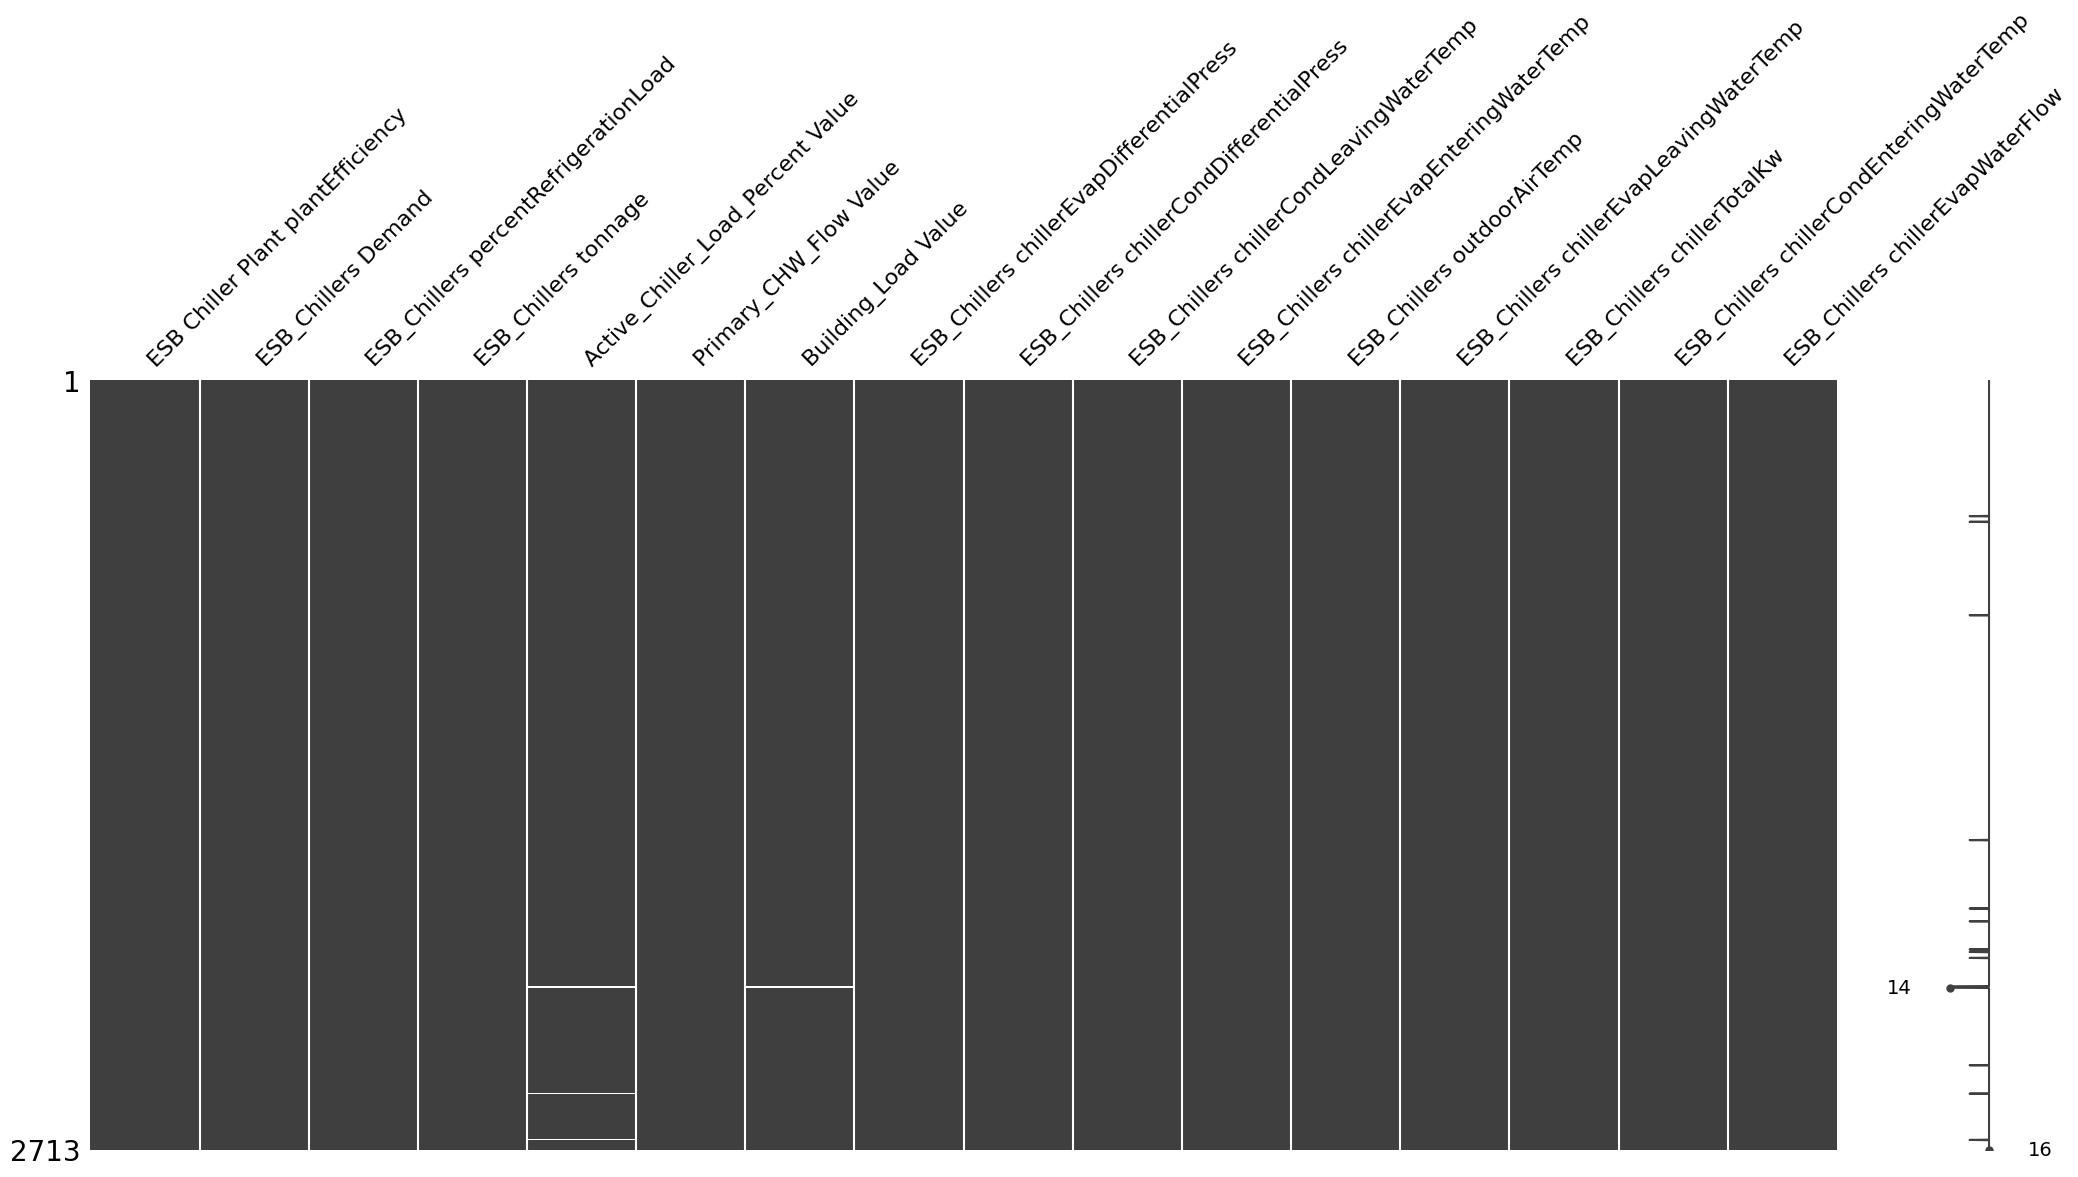

In [7]:
msno.matrix(df_clean.replace(0, np.nan))

<AxesSubplot: >

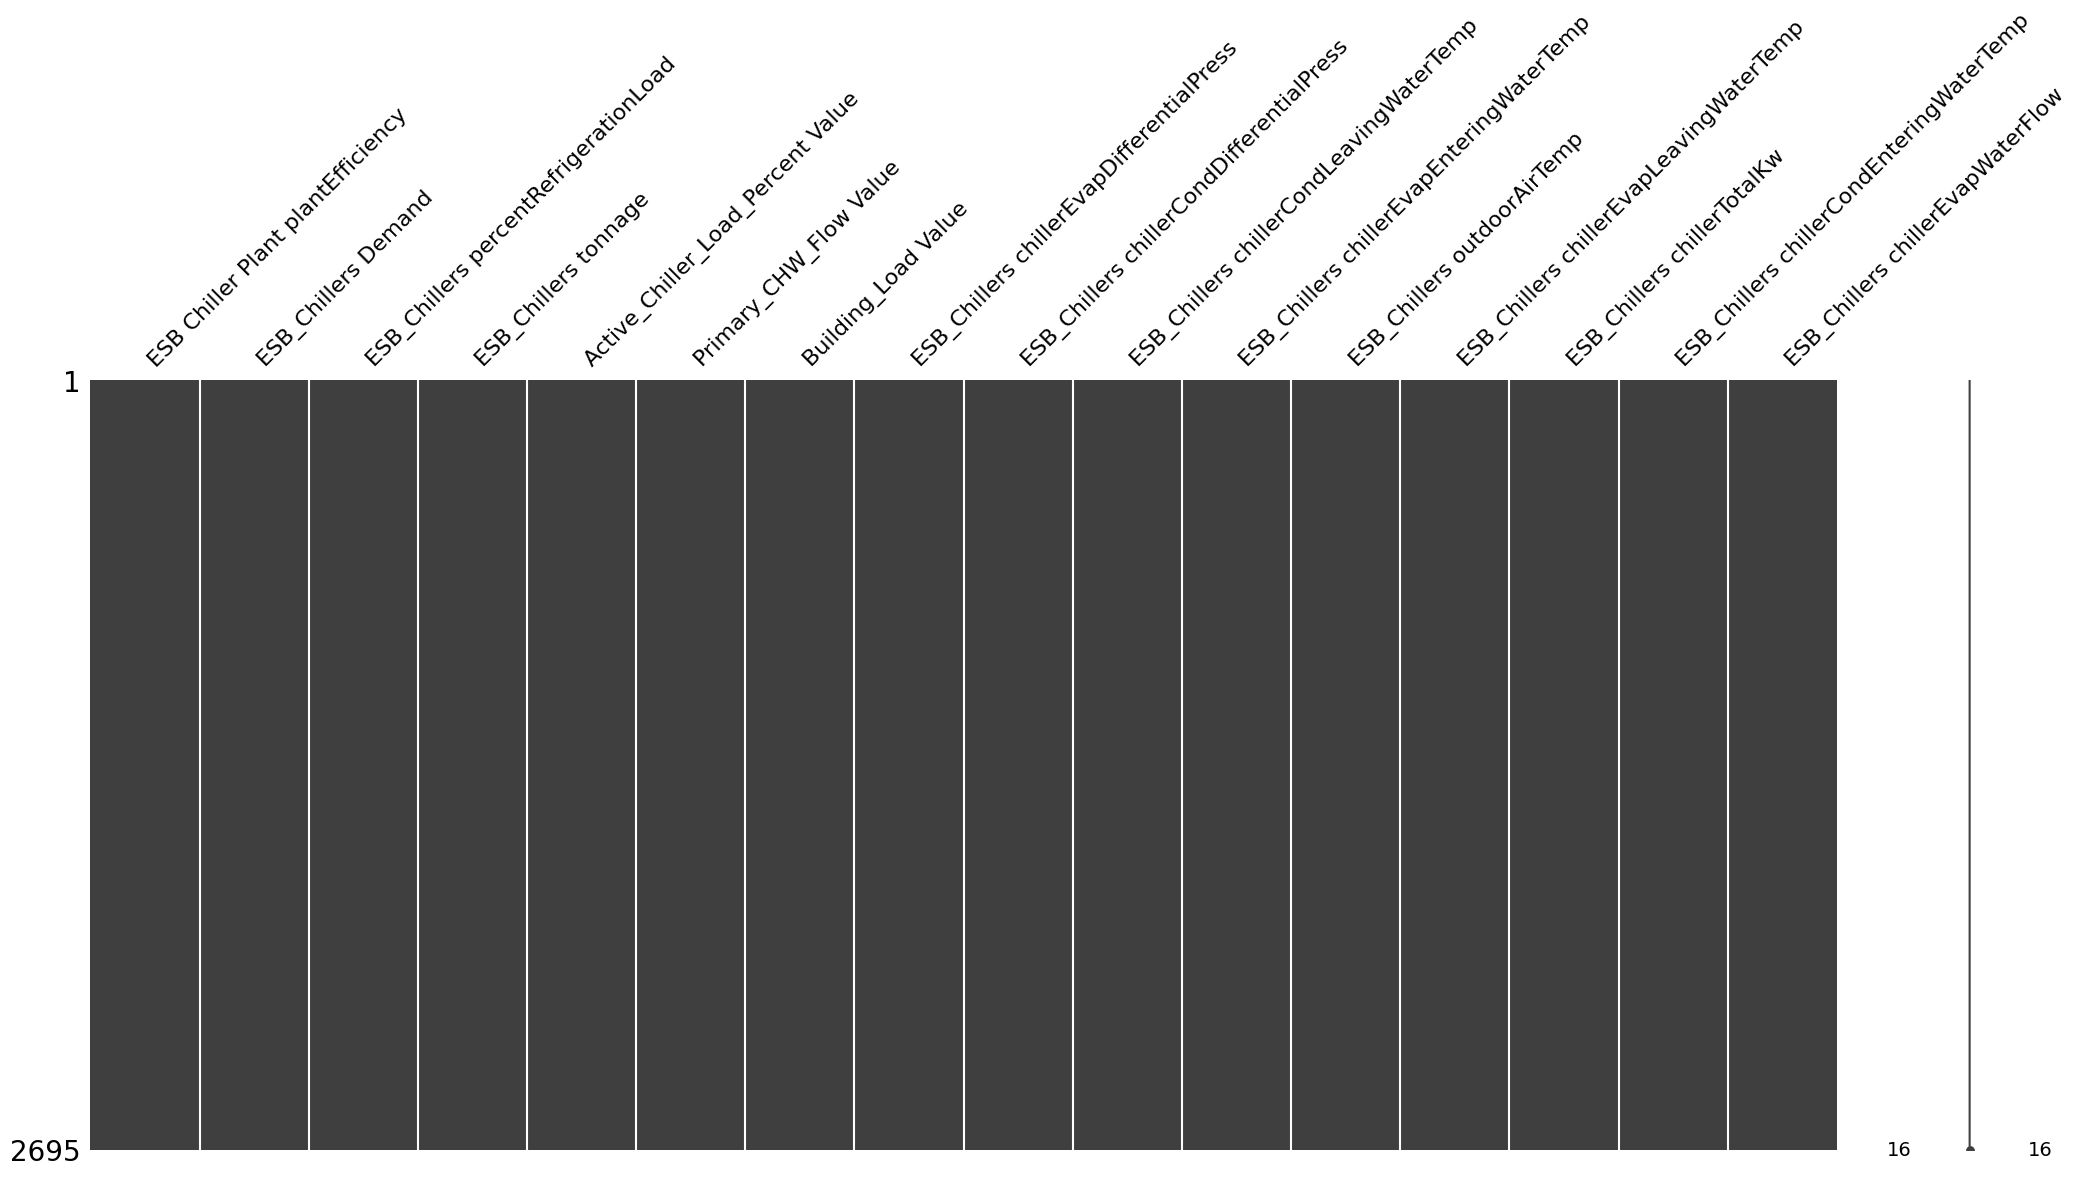

In [8]:
# Label rows as True in "anomaly" if any column in the row has a 0 value
df_anomaly_fall_2021["anomaly"] = df_clean.eq(0).any(axis=1)

# Replace 0 with NaN in df_clean and drop rows with NaN
df_clean.replace(0, np.nan, inplace=True)
df_clean.dropna(inplace=True)

# Visualize the missing data
msno.matrix(df_clean)

In [9]:
df_clean['time'] = df_fall_2021['time']

In [75]:
df_clean.sort_values(by='time', inplace=True)

# Group the DataFrame by date and check the number of entries for each day
counts_by_day = df_clean.groupby(df_clean['time'].dt.date).size()

# Get the dates with incomplete data (less than 24 entries)
incomplete_days = counts_by_day[counts_by_day < 24].index
print(incomplete_days)
# Filter the DataFrame to keep only the rows that belong to complete days
df_fall_2021 = df_clean[~df_clean['time'].dt.date.isin(incomplete_days)]

Index([2020-08-18, 2020-08-25, 2020-08-28, 2020-09-09, 2020-09-11, 2020-09-18,
       2020-09-27, 2020-10-09, 2020-10-10, 2020-10-12, 2020-10-23, 2020-10-24,
       2020-10-29, 2020-10-30, 2020-11-01, 2020-11-02, 2020-11-07, 2020-11-08,
       2020-11-13, 2020-11-15, 2020-11-16, 2020-11-17, 2020-11-18, 2020-11-20,
       2020-11-21, 2020-11-24, 2020-11-26, 2020-11-27, 2020-11-29, 2020-11-30,
       2020-12-01, 2020-12-02, 2020-12-03, 2020-12-04, 2020-12-05, 2020-12-06,
       2020-12-07, 2020-12-08, 2020-12-12],
      dtype='object', name='time')


In [10]:
df_fall_2021 = df_clean.copy()

In [11]:
df_fall_2021['hour'] = df_fall_2021['time'].dt.hour
df_fall_2021['date'] = df_fall_2021['time'].dt.date

# hourly clustering

## Kmeans

In [12]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

def kmeans_evaluation(X, min_clusters, max_clusters):

    silhouette_scores = []

    for n_clusters in range(min_clusters, max_clusters+1):
        kmeans = KMeans(n_clusters=n_clusters)
        kmeans.fit(X)
        labels = kmeans.labels_

        silhouette = silhouette_score(X, labels)

        silhouette_scores.append(silhouette)

        print(f"Number of clusters: {n_clusters}")
        print(f"Silhouette Score: {silhouette}")

    # Find the index of the maximum average score
    best_index = np.argmax(silhouette_scores)

    # Determine the optimal number of clusters based on the majority vote
    best_n_clusters = best_index + min_clusters

    print(f'the best number of clusters is: {best_n_clusters}')

    return best_n_clusters
    

In [13]:
import warnings

scaler = MinMaxScaler()
clusters = {}
warnings.filterwarnings("ignore")
for hour, group in df_fall_2021.groupby('hour'):
    print(f'\nGrouping by hour {hour}...')
    features = group.iloc[:, :16]
    scaled_features = scaler.fit_transform(features)

    optimal_clusters = kmeans_evaluation(scaled_features, 2, 10) 
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
    kmeans.fit(scaled_features)

    clusters[str(hour)] = kmeans.labels_


Grouping by hour 0...
Number of clusters: 2
Silhouette Score: 0.5166955229372437
Number of clusters: 3
Silhouette Score: 0.47378468115859274
Number of clusters: 4
Silhouette Score: 0.4727578646916175
Number of clusters: 5
Silhouette Score: 0.5268146442245683
Number of clusters: 6
Silhouette Score: 0.4901004516692986
Number of clusters: 7
Silhouette Score: 0.49556784135707954
Number of clusters: 8
Silhouette Score: 0.4810739531173337
Number of clusters: 9
Silhouette Score: 0.4761895987280295
Number of clusters: 10
Silhouette Score: 0.4721884479864305
the best number of clusters is: 5

Grouping by hour 1...
Number of clusters: 2
Silhouette Score: 0.512958938155559
Number of clusters: 3
Silhouette Score: 0.46542117961566926
Number of clusters: 4
Silhouette Score: 0.4569486477473961
Number of clusters: 5
Silhouette Score: 0.49773969129823126
Number of clusters: 6
Silhouette Score: 0.48564317537897606
Number of clusters: 7
Silhouette Score: 0.46610915761466015
Number of clusters: 8
Silhoue

In [14]:
kmeans_labeled_fall_2021 = df_fall_2021[['time','date', 'hour']]
kmeans_labeled_fall_2021['hour'] = kmeans_labeled_fall_2021['hour'].astype(str)

kmeans_labeled_fall_2021['kmeans_labels'] = np.nan
for hour, labels in clusters.items():
    kmeans_labeled_fall_2021.loc[kmeans_labeled_fall_2021['hour'] == hour, 'kmeans_labels'] = labels
kmeans_labeled_fall_2021['kmeans_labels'] = (kmeans_labeled_fall_2021['kmeans_labels'].astype(int))
kmeans_labeled_fall_2021['hour'] = kmeans_labeled_fall_2021['hour'].str.split(':').str[0].astype(int)
kmeans_labeled_fall_2021

,time,date,hour,kmeans_labels
12445,2021-08-20 00:00:00,2021-08-20,0,1
12446,2021-08-20 01:00:00,2021-08-20,1,0
12447,2021-08-20 02:00:00,2021-08-20,2,5
12448,2021-08-20 03:00:00,2021-08-20,3,0
12449,2021-08-20 04:00:00,2021-08-20,4,3
...,...,...,...,...
15321,2021-12-17 20:00:00,2021-12-17,20,0
15322,2021-12-17 21:00:00,2021-12-17,21,4
15323,2021-12-17 22:00:00,2021-12-17,22,1
15324,2021-12-17 23:00:00,2021-12-17,23,4


In [15]:
df_anomaly_fall_2021 = df_anomaly_fall_2021.merge(kmeans_labeled_fall_2021[['kmeans_labels']], left_index=True, right_index=True, how='left')
df_anomaly_fall_2021

,ESB Chiller Plant plantEfficiency,ESB_Chillers Demand,ESB_Chillers percentRefrigerationLoad,ESB_Chillers tonnage,Active_Chiller_Load_Percent Value,Primary_CHW_Flow Value,Building_Load Value,ESB_Chillers chillerEvapDifferentialPress,ESB_Chillers chillerCondDifferentialPress,ESB_Chillers chillerCondLeavingWaterTemp,ESB_Chillers chillerEvapEnteringWaterTemp,ESB_Chillers outdoorAirTemp,ESB_Chillers chillerEvapLeavingWaterTemp,ESB_Chillers chillerTotalKw,ESB_Chillers chillerCondEnteringWaterTemp,ESB_Chillers chillerEvapWaterFlow,time,anomaly,kmeans_labels
12445,0.6908,197.33,45.97,367.78,46.11,1817.25,486.95,5.0507,10.8600,83.59,47.14,76.69,42.13,204.1,76.05,1761.91,2021-08-20 00:00:00,False,1.0
12446,0.6764,192.11,45.98,367.87,46.00,1804.59,486.30,5.0589,10.3700,82.99,47.14,76.04,42.13,196.8,75.42,1762.32,2021-08-20 01:00:00,False,0.0
12447,0.6647,187.26,45.89,367.15,43.60,1820.39,468.20,5.0593,10.1300,82.49,47.14,75.52,42.13,190.1,75.02,1758.88,2021-08-20 02:00:00,False,5.0
12448,0.6483,180.86,45.84,366.76,43.88,1820.37,472.06,5.0545,9.9661,81.94,47.14,75.22,42.13,187.5,74.48,1757.00,2021-08-20 03:00:00,False,0.0
12449,0.6510,181.27,45.73,365.84,44.58,1820.24,470.92,5.0547,9.9630,81.77,47.11,74.91,42.13,187.6,74.33,1761.35,2021-08-20 04:00:00,False,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15321,0.5630,92.98,32.95,263.56,31.95,1796.37,369.99,5.2425,-0.8328,67.40,45.65,63.12,41.98,95.7,66.53,1721.85,2021-12-17 20:00:00,False,0.0
15322,0.5624,85.28,31.46,251.67,33.67,1817.41,368.50,5.2421,-0.5623,66.26,45.40,62.59,41.89,93.4,65.68,1723.29,2021-12-17 21:00:00,False,4.0
15323,0.5936,80.73,28.61,228.91,28.74,1807.72,318.55,5.2492,-0.4515,65.45,45.18,61.66,41.98,84.5,65.08,1718.65,2021-12-17 22:00:00,False,1.0
15324,0.5901,79.45,28.50,227.99,29.97,1821.16,351.27,5.2379,-0.5108,65.13,45.20,61.70,42.01,83.2,64.78,1719.62,2021-12-17 23:00:00,False,4.0


In [17]:
from bokeh.palettes import Magma256
from bokeh.plotting import figure, show, output_notebook, output_file, save
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper
from collections import defaultdict
from bokeh.transform import linear_cmap
import numpy as np
from bokeh.models import ColorBar
from bokeh.models import PrintfTickFormatter
from bokeh.models.tickers import BasicTicker

# Convert cluster labels to integer type
kmeans_labeled_fall_2021['kmeans_labels'] = kmeans_labeled_fall_2021['kmeans_labels'].astype(int)

# Extract unique days in the dataset
unique_days = kmeans_labeled_fall_2021['date'].unique()

# Count connections between clusters of two consecutive hours
connection_count = defaultdict(int)
cluster_count = defaultdict(int)
cluster_points = defaultdict(int)

for day in unique_days:
    day_data = kmeans_labeled_fall_2021[kmeans_labeled_fall_2021['date'] == day]
    
    for i in range(len(day_data) - 1):
        hour1, cluster1 = day_data.iloc[i][['hour', 'kmeans_labels']]
        hour2, cluster2 = day_data.iloc[i + 1][['hour', 'kmeans_labels']]
        
        # Connect clusters of two consecutive hours only
        if hour2 - hour1 == 1:
            connection_count[(hour1, cluster1, hour2, cluster2)] += 1
            cluster_count[(hour1, cluster1)] += 1

    for i in range(len(day_data)):
        hour, cluster = day_data.iloc[i][['hour', 'kmeans_labels']]
        cluster_points[(hour, cluster)] += 1

# Prepare data for Bokeh lines
lines_x = []
lines_y = []
counts = []
for (hour1, cluster1, hour2, cluster2), count in connection_count.items():
    percentage = count / cluster_count[(hour1, cluster1)]
    lines_x.append([hour1, hour2])
    lines_y.append([cluster1, cluster2])
    counts.append(percentage)

source_lines = ColumnDataSource(data=dict(
    x=lines_x,
    y=lines_y,
    counts=counts,
))

# Prepare data for Bokeh points
points_x = []
points_y = []
points_count = []
for (hour, cluster), count in cluster_points.items():
    points_x.append(hour)
    points_y.append(cluster)
    points_count.append(count)

source_points = ColumnDataSource(data=dict(
    x=points_x,
    y=points_y,
    counts=points_count,
))

# Define color palette
palette = Magma256[::-1]

# Mapping the edge counts to a color
mapper = LinearColorMapper(palette=palette, low=min(counts), high=max(counts))

# Plotting
p = figure(title="kmeans - Fall 2021", x_axis_label='Hour', y_axis_label='Cluster labels',
           x_range=(-1, 24), y_range=(-1, max(kmeans_labeled_fall_2021['kmeans_labels'])+1), 
           width=1600, height=600, sizing_mode="scale_width", toolbar_location=None)

p.multi_line('x', 'y', source=source_lines, color={'field': 'counts', 'transform': mapper}, line_width=2)
points_renderer = p.circle('x', 'y', color='black', size=10, source=source_points)

color_bar = ColorBar(color_mapper=mapper, label_standoff=12, location=(0, 0),
                     ticker=BasicTicker(desired_num_ticks=len(palette)),
                     formatter=PrintfTickFormatter(format="%0.2f%%"))

p.add_layout(color_bar, 'right')

# Add a hover tool to display the count
hover_line = HoverTool(tooltips=[("Connectivity (%)", "@counts{0.2f}")], 
                       line_policy='nearest', point_policy='snap_to_data', 
                       renderers=[p.renderers[0]])

hover_point = HoverTool(tooltips=[("Cluster size", "@counts")], 
                        mode='mouse', renderers=[points_renderer])

p.add_tools(hover_line, hover_point)

# Display the plot
output_notebook()
show(p)

# Save the plot
output_file("./connectivity_plot/fall/2021/connectivity_plot_kmeans.html")
save(p)

Loading BokehJS ...

'z:\\home\\rhea_huang\\isis\\ESB_Anomaly_Detection\\chillers\\connectivity_plot\\fall\\2021\\connectivity_plot_kmeans.html'

In [18]:
# Convert cluster labels to integer type
kmeans_labeled_fall_2021['kmeans_labels'] = kmeans_labeled_fall_2021['kmeans_labels'].astype(int)

# Extract unique days in the dataset
unique_days = kmeans_labeled_fall_2021['date'].unique()

# Count connections between clusters of two consecutive hours
connection_count = defaultdict(int)
cluster_count = defaultdict(int)
cluster_points = defaultdict(int)

for day in unique_days:
    day_data = kmeans_labeled_fall_2021[kmeans_labeled_fall_2021['date'] == day]
    
    for i in range(len(day_data) - 1):
        hour1, cluster1 = day_data.iloc[i][['hour', 'kmeans_labels']]
        hour2, cluster2 = day_data.iloc[i + 1][['hour', 'kmeans_labels']]
        
        # Connect clusters of two consecutive hours only
        if hour2 - hour1 == 1:
            connection_count[(hour1, cluster1, hour2, cluster2)] += 1
            cluster_count[(hour1, cluster1)] += 1

    for i in range(len(day_data)):
        hour, cluster = day_data.iloc[i][['hour', 'kmeans_labels']]
        cluster_points[(hour, cluster)] += 1

In [19]:
def generate_path(connection_count, cluster_count, start_hour, start_cluster, threshold):
    path = []
    current_hour = start_hour
    current_cluster = start_cluster
    while True:
        path.append((current_hour, current_cluster))
        next_clusters = []
        for (hour1, cluster1, hour2, cluster2), count in connection_count.items():
            if hour1 == current_hour and cluster1 == current_cluster and hour2 == current_hour + 1:
                if cluster_count[(hour1, cluster1)] != 0:
                    next_clusters.append((hour2, cluster2, count / cluster_count[(hour1, cluster1)]))
                else:
                    continue

        if not next_clusters:
            break

        # Sort clusters of the next hour by the connection ratio
        next_clusters.sort(key=lambda x: x[2], reverse=True)

        # Get the cluster with the highest connection ratio
        _, current_cluster, highest_ratio = next_clusters[0]

        if highest_ratio < threshold:
            break

        current_hour += 1

    return path

In [20]:
from collections import defaultdict, Counter
from bokeh.models import ColumnDataSource, LinearColorMapper, ColorBar, PrintfTickFormatter, BasicTicker
from bokeh.plotting import figure, output_file, save
from bokeh.palettes import Magma256
from bokeh.models.tools import HoverTool


palette = Magma256[::-1]

threshold = 0.9
clusters = range(max(kmeans_labeled_fall_2021['kmeans_labels'])+1)
hours = range(24)

# Create a boolean array to keep track of whether a cluster at an hour is the end of a path
end_points = defaultdict(lambda: defaultdict(lambda: True))

paths = []  # List to save the paths
idx = 0
for start_hour in hours:
    for start_cluster in clusters:
        path = generate_path(connection_count, cluster_count, start_hour, start_cluster, threshold)
        
        # If path length is less than 2, don't add it to the paths list
        if len(path) < 2:
            continue

        # If the ending cluster at the ending hour is not the end of a path
        if not end_points[path[-1][0]][path[-1][1]]:
            continue

        # Update end_points for the clusters in the path
        for h, c in path:
            end_points[h][c] = False
        
        # Add the path to the paths list
        paths.append(path)

        lines_x = []
        lines_y = []
        counts = []
        points_x = []
        points_y = []
        points_counts = []

        # Create a set to keep track of the points that have been added
        added_points = set()

        for i in range(len(path) - 1):  # Notice the "- 1" here, to avoid going beyond the end of the path
            hour1, cluster1 = path[i]
            points_x.append(hour1)
            points_y.append(cluster1)

            if i == 0:
                points_counts.append(cluster_count[(hour1, cluster1)])
            else:
                # Otherwise, get the transition count from the previous hour and cluster
                points_counts.append(connection_count[(path[i-1][0], path[i-1][1], hour1, cluster1)])

            hour2, cluster2 = path[i + 1]
            count = connection_count[(hour1, cluster1, hour2, cluster2)]
            lines_x.append([hour1, hour2])
            lines_y.append([cluster1, cluster2])

            # Check if cluster_count[(hour1, cluster1)] is zero before performing the division
            if cluster_count[(hour1, cluster1)] != 0:
                count_percentage = count / cluster_count[(hour1, cluster1)]
                counts.append(count_percentage)

        # Add the last point
        hour1, cluster1 = path[-1]

        points_x.append(hour1)
        points_y.append(cluster1)
        points_counts.append(connection_count[(path[-2][0], path[-2][1], hour1, cluster1)])

        p = figure(title=f"Threshold: {threshold*100}% - Path {idx + 1}", 
                x_axis_label='Hour', y_axis_label='Cluster',
                x_range=(-1, 24), y_range=(-1, max(clusters)+1), 
                width=800, height=400, toolbar_location=None)

        mapper = LinearColorMapper(palette=palette, low=min(counts), high=max(counts))
        color_bar = ColorBar(color_mapper=mapper, label_standoff=12, location=(0, 0),
                            ticker=BasicTicker(desired_num_ticks=len(palette)),
                            formatter=PrintfTickFormatter(format="%0.2f%%"))
        p.add_layout(color_bar, 'right')

        line_source = ColumnDataSource(data=dict(x=lines_x, y=lines_y, counts=counts))
        point_source = ColumnDataSource(data=dict(points_x=points_x, points_y=points_y, points_counts=points_counts))

        p.multi_line('x', 'y', source=line_source, color={'field': 'counts', 'transform': mapper}, line_width=2)
        points_renderer = p.circle('points_x', 'points_y', color='black', size=10, source=point_source)

        hover_line = HoverTool(tooltips=[("Connectivity (%)", "@counts{0.2f}")], 
                            mode='mouse', line_policy='nearest', point_policy='snap_to_data')
        hover_point = HoverTool(tooltips=[("Size", "@points_counts")], 
                                mode='mouse', renderers=[points_renderer])

        p.add_tools(hover_line, hover_point)

        output_file(f"./connectivity_plot/fall/2021/kmeans/connectivity_plot_kmeans_{int(threshold*100)}_path_{idx + 1}.html")
        save(p)
        idx += 1

#### generate paths for same day

In [21]:
from collections import defaultdict, Counter
from bokeh.models import ColumnDataSource, LinearColorMapper, ColorBar, PrintfTickFormatter, BasicTicker
from bokeh.plotting import figure, output_file, save
from bokeh.palettes import Magma256
from bokeh.models.tools import HoverTool


threshold = 0.9
clusters = range(max(kmeans_labeled_fall_2021['kmeans_labels'])+1)
hours = range(24)

# Create a boolean array to keep track of whether a cluster at an hour is the end of a path
end_points = defaultdict(lambda: defaultdict(lambda: True))

paths = []  # List to save the paths
idx = 0
for start_hour in hours:
    for start_cluster in clusters:
        path = generate_path(connection_count, cluster_count, start_hour, start_cluster, threshold)
        
        # If path length is less than 2, don't add it to the paths list
        if len(path) < 2:
            continue

        # If the ending cluster at the ending hour is not the end of a path
        if not end_points[path[-1][0]][path[-1][1]]:
            continue

        # Update end_points for the clusters in the path
        for h, c in path:
            end_points[h][c] = False
        
        # Add the path to the paths list
        paths.append(path)

In [22]:
len(paths)

17

In [23]:
def find_pattern(day_data, patterns):
    # Initialize pattern index with None
    day_data['pattern_index'] = None

    for i in range(len(day_data) - 1):
        # Check if the current and next (hour, cluster) pairs match the first two hours of any pattern
        for pattern_index, pattern in enumerate(patterns):
            if (day_data.iloc[i]['hour'], day_data.iloc[i]['kmeans_labels']) == pattern[0] and \
               (day_data.iloc[i + 1]['hour'], day_data.iloc[i + 1]['kmeans_labels']) == pattern[1]:
                # If there's a match, set the pattern index for these hours
                day_data.loc[day_data.index[i], 'pattern_index'] = pattern_index + 1
                day_data.loc[day_data.index[i + 1], 'pattern_index'] = pattern_index + 1

                # Try to continue with the same pattern for the rest hours of the day
                for j in range(i + 2, len(day_data)):
                    # Check if the current hour is less than the length of the pattern
                    if j - i < len(pattern) and (day_data.iloc[j]['hour'], day_data.iloc[j]['kmeans_labels']) == pattern[j - i]:
                        day_data.loc[day_data.index[j], 'pattern_index'] = pattern_index + 1
                    else:
                        # If the pattern can't continue, break the loop
                        break
                else:
                    # If we've reached the end of the pattern, assign the pattern index to the last element
                    if j == len(day_data) - 1 and j - i == len(pattern):
                        day_data.loc[day_data.index[j], 'pattern_index'] = pattern_index + 1
                break

    return day_data

# Apply the function on each day and concatenate the results
kmeans_labeled_fall_2021 = pd.concat(find_pattern(day_data, paths) for _, day_data in kmeans_labeled_fall_2021.groupby('date'))

In [24]:
kmeans_labeled_fall_2021[kmeans_labeled_fall_2021['pattern_index'].notnull()]

,time,date,hour,kmeans_labels,pattern_index
12445,2021-08-20 00:00:00,2021-08-20,0,1,2
12446,2021-08-20 01:00:00,2021-08-20,1,0,2
12447,2021-08-20 02:00:00,2021-08-20,2,5,8
12448,2021-08-20 03:00:00,2021-08-20,3,0,8
12449,2021-08-20 04:00:00,2021-08-20,4,3,10
...,...,...,...,...,...
15320,2021-12-17 19:00:00,2021-12-17,19,0,12
15321,2021-12-17 20:00:00,2021-12-17,20,0,12
15322,2021-12-17 21:00:00,2021-12-17,21,4,16
15323,2021-12-17 22:00:00,2021-12-17,22,1,16


In [25]:
df_anomaly_fall_2021 = df_anomaly_fall_2021.merge(kmeans_labeled_fall_2021[['pattern_index']], left_index=True, right_index=True, how='left')
df_anomaly_fall_2021

,ESB Chiller Plant plantEfficiency,ESB_Chillers Demand,ESB_Chillers percentRefrigerationLoad,ESB_Chillers tonnage,Active_Chiller_Load_Percent Value,Primary_CHW_Flow Value,Building_Load Value,ESB_Chillers chillerEvapDifferentialPress,ESB_Chillers chillerCondDifferentialPress,ESB_Chillers chillerCondLeavingWaterTemp,ESB_Chillers chillerEvapEnteringWaterTemp,ESB_Chillers outdoorAirTemp,ESB_Chillers chillerEvapLeavingWaterTemp,ESB_Chillers chillerTotalKw,ESB_Chillers chillerCondEnteringWaterTemp,ESB_Chillers chillerEvapWaterFlow,time,anomaly,kmeans_labels,pattern_index
12445,0.6908,197.33,45.97,367.78,46.11,1817.25,486.95,5.0507,10.8600,83.59,47.14,76.69,42.13,204.1,76.05,1761.91,2021-08-20 00:00:00,False,1.0,2
12446,0.6764,192.11,45.98,367.87,46.00,1804.59,486.30,5.0589,10.3700,82.99,47.14,76.04,42.13,196.8,75.42,1762.32,2021-08-20 01:00:00,False,0.0,2
12447,0.6647,187.26,45.89,367.15,43.60,1820.39,468.20,5.0593,10.1300,82.49,47.14,75.52,42.13,190.1,75.02,1758.88,2021-08-20 02:00:00,False,5.0,8
12448,0.6483,180.86,45.84,366.76,43.88,1820.37,472.06,5.0545,9.9661,81.94,47.14,75.22,42.13,187.5,74.48,1757.00,2021-08-20 03:00:00,False,0.0,8
12449,0.6510,181.27,45.73,365.84,44.58,1820.24,470.92,5.0547,9.9630,81.77,47.11,74.91,42.13,187.6,74.33,1761.35,2021-08-20 04:00:00,False,3.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15321,0.5630,92.98,32.95,263.56,31.95,1796.37,369.99,5.2425,-0.8328,67.40,45.65,63.12,41.98,95.7,66.53,1721.85,2021-12-17 20:00:00,False,0.0,12
15322,0.5624,85.28,31.46,251.67,33.67,1817.41,368.50,5.2421,-0.5623,66.26,45.40,62.59,41.89,93.4,65.68,1723.29,2021-12-17 21:00:00,False,4.0,16
15323,0.5936,80.73,28.61,228.91,28.74,1807.72,318.55,5.2492,-0.4515,65.45,45.18,61.66,41.98,84.5,65.08,1718.65,2021-12-17 22:00:00,False,1.0,16
15324,0.5901,79.45,28.50,227.99,29.97,1821.16,351.27,5.2379,-0.5108,65.13,45.20,61.70,42.01,83.2,64.78,1719.62,2021-12-17 23:00:00,False,4.0,16


In [26]:
df_anomaly_fall_2021['hour'] = df_anomaly_fall_2021['time'].dt.hour
df_anomaly_fall_2021["pattern"] = None

In [27]:
df_anomaly_fall_2021.to_csv('./data/df_anomaly_fall_2021.csv', index=True)

In [102]:
result_fall_2021 = pd.read_csv('./data/df_anomaly_fall_2021.csv', index_col=0)

NameError: name 'read_csv' is not defined

### plot features

In [28]:
kmeans_labeled_fall_2021

,time,date,hour,kmeans_labels,pattern_index
12445,2021-08-20 00:00:00,2021-08-20,0,1,2
12446,2021-08-20 01:00:00,2021-08-20,1,0,2
12447,2021-08-20 02:00:00,2021-08-20,2,5,8
12448,2021-08-20 03:00:00,2021-08-20,3,0,8
12449,2021-08-20 04:00:00,2021-08-20,4,3,10
...,...,...,...,...,...
15321,2021-12-17 20:00:00,2021-12-17,20,0,12
15322,2021-12-17 21:00:00,2021-12-17,21,4,16
15323,2021-12-17 22:00:00,2021-12-17,22,1,16
15324,2021-12-17 23:00:00,2021-12-17,23,4,16


In [29]:
import datetime
df_labeled_fall_2021 = df_fall_2021.copy()
df_labeled_fall_2021['kmeans_labels'] = kmeans_labeled_fall_2021['kmeans_labels']
df_labeled_fall_2021['pattern_index'] = kmeans_labeled_fall_2021['pattern_index']
df_labeled_fall_2021['day_of_week'] = df_labeled_fall_2021['time'].dt.strftime('%A')

weekday_to_num = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
df_labeled_fall_2021['day_of_week'] = df_labeled_fall_2021['day_of_week'].map(weekday_to_num)
df_labeled_fall_2021

,ESB Chiller Plant plantEfficiency,ESB_Chillers Demand,ESB_Chillers percentRefrigerationLoad,ESB_Chillers tonnage,Active_Chiller_Load_Percent Value,Primary_CHW_Flow Value,Building_Load Value,ESB_Chillers chillerEvapDifferentialPress,ESB_Chillers chillerCondDifferentialPress,ESB_Chillers chillerCondLeavingWaterTemp,...,ESB_Chillers chillerEvapLeavingWaterTemp,ESB_Chillers chillerTotalKw,ESB_Chillers chillerCondEnteringWaterTemp,ESB_Chillers chillerEvapWaterFlow,time,hour,date,kmeans_labels,pattern_index,day_of_week
12445,0.6908,197.33,45.97,367.78,46.11,1817.25,486.95,5.0507,10.8600,83.59,...,42.13,204.1,76.05,1761.91,2021-08-20 00:00:00,0,2021-08-20,1,2,4
12446,0.6764,192.11,45.98,367.87,46.00,1804.59,486.30,5.0589,10.3700,82.99,...,42.13,196.8,75.42,1762.32,2021-08-20 01:00:00,1,2021-08-20,0,2,4
12447,0.6647,187.26,45.89,367.15,43.60,1820.39,468.20,5.0593,10.1300,82.49,...,42.13,190.1,75.02,1758.88,2021-08-20 02:00:00,2,2021-08-20,5,8,4
12448,0.6483,180.86,45.84,366.76,43.88,1820.37,472.06,5.0545,9.9661,81.94,...,42.13,187.5,74.48,1757.00,2021-08-20 03:00:00,3,2021-08-20,0,8,4
12449,0.6510,181.27,45.73,365.84,44.58,1820.24,470.92,5.0547,9.9630,81.77,...,42.13,187.6,74.33,1761.35,2021-08-20 04:00:00,4,2021-08-20,3,10,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15321,0.5630,92.98,32.95,263.56,31.95,1796.37,369.99,5.2425,-0.8328,67.40,...,41.98,95.7,66.53,1721.85,2021-12-17 20:00:00,20,2021-12-17,0,12,4
15322,0.5624,85.28,31.46,251.67,33.67,1817.41,368.50,5.2421,-0.5623,66.26,...,41.89,93.4,65.68,1723.29,2021-12-17 21:00:00,21,2021-12-17,4,16,4
15323,0.5936,80.73,28.61,228.91,28.74,1807.72,318.55,5.2492,-0.4515,65.45,...,41.98,84.5,65.08,1718.65,2021-12-17 22:00:00,22,2021-12-17,1,16,4
15324,0.5901,79.45,28.50,227.99,29.97,1821.16,351.27,5.2379,-0.5108,65.13,...,42.01,83.2,64.78,1719.62,2021-12-17 23:00:00,23,2021-12-17,4,16,4


In [32]:
import matplotlib.pyplot as plt
import os
def plot_features(df, lines_x, lines_y, points_x, points_y, threshold, method):
    features = df.columns[:-5]

    # use tab10 colormap
    cmap = plt.get_cmap('tab10')

    for idx, (line_x, line_y, point_x, point_y) in enumerate(zip(lines_x, lines_y, points_x, points_y)):
        
        # Create a directory for each path
        dir_name = f"./connectivity_plot/fall/2021_feature_visualization/{method}/{idx + 1}"
        os.makedirs(dir_name, exist_ok=True)

        for feature_idx, feature in enumerate(features):
            plt.figure(figsize=(20,10))

            for hour in range(24):
                # get all points belonging to the cluster of that hour
                cluster = point_y[point_x.index(hour) if hour in point_x else -1]
                same_cluster_points = df[(df['hour'] == hour) & (df[method] == cluster)]
                feature_values = same_cluster_points[feature].tolist()

                # accommodate -1 values for dbscan_labels
                color_code = cluster if cluster >= 0 else len(df[method].unique()) - 1
                cluster_colors = [cmap(color_code % 10)] * len(feature_values)

                # plot for each feature
                plt.scatter([hour]*len(feature_values), feature_values, color=cluster_colors)

            plt.title(f"{method} - Fall 2021, Threshold: {threshold*100}% - Path {idx + 1} - Feature: {feature}")
            plt.xlabel('Hour')
            plt.ylabel(feature)
            plt.xlim(-1, 25)

            # create legend
            clusters = df[method].unique()
            legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                          markerfacecolor=cmap(cluster if cluster >= 0 else len(clusters) - 1), 
                                          markersize=10) for cluster in clusters]
            plt.legend(legend_elements, clusters, title="Clusters")

            # Save the figure to a file
            plt.savefig(f"{dir_name}/{feature_idx + 1}.png")

            # Clear the current figure to free memory
            plt.clf()

In [33]:
import matplotlib.pyplot as plt
import os
import numpy as np

def plot_features(df, method):
    features = df.columns[:-6]

    # Define the color map for the days of the week
    cmap = plt.get_cmap('tab10')

    # Get the unique paths but exclude None
    paths = df[df['pattern_index'].notna()]['pattern_index'].unique()

    # Ensure 'date' is of type string
    df['date'] = df['date'].astype(str)

    for idx, path in enumerate(paths):
        # Create a directory for each path
        dir_name = f"./connectivity_plot/fall/2021_feature_visualization/{method}/{path}"
        os.makedirs(dir_name, exist_ok=True)

        path_df = df[df['pattern_index'] == path]

        # Count the number of unique dates for each day of the week
        day_counts = path_df.groupby('day_of_week')['date'].nunique()

        for feature_idx, feature in enumerate(features):
            plt.figure(figsize=(20,10))

            # Group by 'day_of_week' and plot a line for each day
            for day, day_group in path_df.groupby('day_of_week'):
                for date, date_group in day_group.groupby('date'):
                    hours = date_group['hour'].values
                    feature_values = date_group[feature].values

                    plt.plot(hours, feature_values, color=cmap(day), label=str(date))
                    plt.scatter(hours, feature_values, color=cmap(day))
                    plt.text(hours[-1], feature_values[-1], str(date), fontsize=9)

            plt.title(f"{method} - Fall 2021 - Path {path} - Feature: {feature}")
            plt.xlabel('Hour')
            plt.ylabel(feature)
            plt.xlim(-1, 25)

            # create legend
            day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
            legend_elements = [plt.Line2D([0], [0], color=cmap(i), lw=2, label=f'{day_names[i]}: {day_counts.get(i, 0)}') for i in range(7)]
            plt.legend(handles=legend_elements, loc='upper right', title="Days of the Week")

            # Save the figure to a file
            plt.savefig(f"{dir_name}/{feature_idx + 1}.png")

            # Clear the current figure to free memory
            plt.clf()


In [34]:
plot_features(df_labeled_fall_2021, method='kmeans_labels')

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

In [90]:
df_labeled_fall_2021

,ESB Chiller Plant plantEfficiency,ESB_Chillers Demand,ESB_Chillers percentRefrigerationLoad,ESB_Chillers tonnage,Active_Chiller_Load_Percent Value,Primary_CHW_Flow Value,Building_Load Value,ESB_Chillers chillerEvapDifferentialPress,ESB_Chillers chillerCondDifferentialPress,ESB_Chillers chillerCondLeavingWaterTemp,...,ESB_Chillers chillerEvapLeavingWaterTemp,ESB_Chillers chillerTotalKw,ESB_Chillers chillerCondEnteringWaterTemp,ESB_Chillers chillerEvapWaterFlow,time,hour,date,kmeans_labels,pattern_index,day_of_week
3652,0.5959,170.71,47.51,380.06,45.91,1822.90,478.74,5.2324,4.7747,82.08,...,42.28,187.61,77.68,1731.39,2020-08-18 14:00:00,14,2020-08-18,2,None,1
3653,0.6130,184.15,48.91,391.24,51.58,1816.70,525.64,5.2285,4.7490,83.68,...,42.48,192.96,78.91,1732.55,2020-08-18 15:00:00,15,2020-08-18,2,None,1
3654,0.6068,190.43,50.61,404.91,49.46,1808.71,504.16,5.2223,4.7537,83.79,...,42.14,200.71,79.02,1732.96,2020-08-18 16:00:00,16,2020-08-18,2,None,1
3655,0.6092,186.75,49.74,397.93,49.89,1831.57,510.50,5.2269,4.7729,83.23,...,42.16,190.17,78.64,1732.45,2020-08-18 17:00:00,17,2020-08-18,2,None,1
3656,0.6368,181.22,46.49,371.95,48.90,1817.68,499.74,5.2091,4.7657,83.06,...,42.28,190.95,78.69,1730.71,2020-08-18 18:00:00,18,2020-08-18,2,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6418,0.5070,54.38,23.04,184.31,24.52,1817.69,291.69,5.1988,0.5605,61.23,...,41.93,59.80,57.71,1723.81,2020-12-11 20:00:00,20,2020-12-11,0,None,4
6419,0.5300,53.23,21.79,174.32,24.38,1817.91,295.17,5.1921,0.4446,61.15,...,41.88,59.01,57.44,1721.30,2020-12-11 21:00:00,21,2020-12-11,1,None,4
6420,0.5242,53.69,22.22,177.79,24.14,1817.72,298.21,5.1828,0.4626,61.05,...,41.86,57.49,57.32,1722.44,2020-12-11 22:00:00,22,2020-12-11,2,None,4
6421,0.5393,54.06,21.62,172.92,20.16,1821.58,261.70,5.1894,0.7068,61.26,...,41.91,57.15,57.94,1722.57,2020-12-11 23:00:00,23,2020-12-11,3,None,4


### analyze paths

In [30]:
import pandas as pd

def analyze_paths(df, method):
    features = df.columns[:-6]
    day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

    # Ensure 'date' is of type string
    df['date'] = df['date'].astype(str)

    # Initialize an empty list to store dictionaries of data for each path
    path_data = []

    # Get the unique paths but exclude None
    paths = df[df['pattern_index'].notna()]['pattern_index'].unique()

    for idx, path in enumerate(paths):
        # Extract the data for this path
        path_df = df[df['pattern_index'] == path]

        # Count the number of unique dates for each day of the week
        day_counts = path_df.groupby('day_of_week')['date'].nunique()

        # Initialize a dictionary to store data for this path
        path_dict = {}

        # Store the path number
        path_dict['path'] = path

        # Store the range of hours for this path
        min_hour = path_df['hour'].min()
        max_hour = path_df['hour'].max()

        # convert the hours to a 12-hour format with am/pm
        min_hour_str = f'{min_hour % 12 or 12}{"am" if min_hour < 12 else "pm"}'
        max_hour_str = f'{max_hour % 12 or 12}{"am" if max_hour < 12 else "pm"}'

        path_dict['hour_of_day'] = f'{min_hour_str}-{max_hour_str}'

        # Store the date range for this path
        min_date = path_df['date'].min()
        max_date = path_df['date'].max()
        path_dict['date_range'] = f'{min_date} - {max_date}'

        # Store the range of each feature for this path
        for feature in features:
            min_feature = path_df[feature].min()
            max_feature = path_df[feature].max()
            path_dict[f'{feature}_range'] = f'{min_feature}-{max_feature}'

        # Store the count of each day of the week for this path
        for i in range(7):
            path_dict[day_names[i]] = day_counts.get(i, 0)

        # Add this path's data to the list
        path_data.append(path_dict)

    # Convert the list of dictionaries into a DataFrame
    path_df = pd.DataFrame(path_data)
    path_df = path_df.sort_values('path')

    # Save the DataFrame to a CSV file
    path_df.to_csv(f'./connectivity_plot/fall/2021/{method}/path_summary_2021.csv', index=False)

    return path_df


In [32]:
analyze_paths(df_labeled_fall_2021, method='kmeans')

,path,hour_of_day,date_range,ESB Chiller Plant plantEfficiency_range,ESB_Chillers Demand_range,ESB_Chillers percentRefrigerationLoad_range,ESB_Chillers tonnage_range,Active_Chiller_Load_Percent Value_range,Primary_CHW_Flow Value_range,Building_Load Value_range,...,ESB_Chillers chillerTotalKw_range,ESB_Chillers chillerCondEnteringWaterTemp_range,ESB_Chillers chillerEvapWaterFlow_range,Mon,Tue,Wed,Thu,Fri,Sat,Sun
14,1,12am-1am,2021-11-03 - 2021-12-13,0.738-1.08,43.7-54.33,8.6331-12.51,69.06-100.07,6.7441-12.31,1793.03-1851.7,173.9-222.3,...,48.0-78.7,55.8-61.41,1751.9-1758.8,3,2,3,2,3,3,2
0,2,12am-1am,2021-08-20 - 2021-12-11,0.5869-0.7143,145.43-211.75,41.34-48.58,330.71-388.64,37.51-49.52,1804.03-1848.01,419.49-518.46,...,155.8-218.8,68.77-77.28,1758.49-1764.29,2,1,1,2,2,3,2
9,3,2am-9am,2021-09-24 - 2021-12-17,0.4737-1.3287,36.03-78.69,11.13-29.49,89.07-235.93,10.63-39.21,1779.98-1868.75,187.43-399.26,...,40.7-102.9,56.26-65.12,1717.29-1736.0,1,2,1,1,3,3,2
5,4,2am-11am,2021-08-31 - 2021-10-15,0.5311-0.6876,117.88-293.81,38.33-66.46,306.67-531.65,37.04-67.56,1796.93-1857.92,410.09-669.16,...,121.6-335.3,69.95-80.15,1714.26-1735.06,4,5,5,3,3,3,4
6,5,2am-3am,2021-09-03 - 2021-12-06,0.5485-0.5993,48.13-110.39,16.03-35.72,128.22-285.76,22.56-35.88,1803.19-1847.03,304.64-409.63,...,78.8-124.2,57.71-64.06,1751.42-1759.64,1,0,1,1,1,1,0
12,6,2am-11am,2021-10-27 - 2021-12-15,0.5-0.9219,45.87-87.74,10.66-30.81,85.28-246.46,7.3107-39.97,1796.07-1861.28,179.6-421.12,...,48.5-130.3,55.92-61.59,1745.55-1756.9,3,4,4,4,3,1,4
15,7,2am-7am,2021-11-03 - 2021-12-14,0.6247-1.22,42.67-57.26,8.8978-13.53,71.18-108.23,2.9533-20.11,1786.47-1853.68,161.74-276.9,...,44.7-89.1,56.33-62.14,1751.0-1759.1,3,3,3,2,3,4,3
1,8,2am-3am,2021-08-20 - 2021-12-11,0.5775-0.7126,132.7-260.88,40.62-64.77,324.98-518.17,40.78-62.52,1802.51-1860.67,444.1-624.1,...,135.9-265.9,67.07-76.58,1756.45-1764.61,2,1,1,2,2,3,2
7,9,2am-4am,2021-09-07 - 2021-10-21,0.5417-1.2789,71.61-161.78,13.52-39.33,108.2-314.62,12.5-37.66,1791.0-1849.5,202.45-411.03,...,80.6-170.3,63.74-76.06,1718.1-1734.49,1,2,1,3,1,1,1
2,10,4am-1pm,2021-08-20 - 2021-08-30,0.6132-0.7113,180.71-306.25,44.23-71.66,353.83-573.31,43.23-71.81,1796.77-1832.56,465.58-693.44,...,187.6-318.9,74.33-79.3,1757.53-1767.24,2,1,1,1,2,2,2


### Preparing X for model development

In [38]:
df['date']

NameError: name 'df' is not defined

In [107]:
import pandas as pd

# # Assuming 'df' and 'df_fall_2021' are your dataframes

# # Step 1: Create 'date' and 'hour' columns in df_fall_2021 based on 'time'
# df_fall_2021['hour'] = pd.to_datetime(df_fall_2021['time']).dt.hour
# df_fall_2021['date'] = pd.to_datetime(df_fall_2021['time']).dt.date

# # Initialize the three columns with NaN values
# df_fall_2021['kmeans_labels'] = None
# df_fall_2021['pattern_index'] = None
# df_fall_2021['day_of_week'] = None

# df_fall_2021['date'] = df_fall_2021['date'].apply(lambda x: x.strftime('%Y-%m-%d'))


merged_df = df.copy()

# Get unique dates in df
dates_in_df = df['date'].unique()

# A list to collect all missing rows
missing_rows = []

# Loop through unique dates
for date in dates_in_df:
    df_subset = df[df['date'] == date]
    df_fall_subset = df_fall_2021[df_fall_2021['date'] == date]
    matching_hours = set(df_subset['hour'].values)
    
    missing_hours = set(range(24)) - matching_hours
    
    for missing_hour in missing_hours:
        # Find the corresponding row in df_fall_2021
        row_to_insert = df_fall_subset[df_fall_subset['hour'] == missing_hour]
        missing_rows.append(row_to_insert)

# Concatenate missing rows with merged_df
merged_df = pd.concat([merged_df] + missing_rows, ignore_index=True)

# Sort the final result by date and hour
merged_df = merged_df.sort_values(by=['date', 'hour']).reset_index(drop=True)
merged_df

,ESB Chiller Plant plantEfficiency,ESB_Chillers Demand,ESB_Chillers percentRefrigerationLoad,ESB_Chillers tonnage,Active_Chiller_Load_Percent Value,Primary_CHW_Flow Value,Building_Load Value,ESB_Chillers chillerEvapDifferentialPress,ESB_Chillers chillerCondDifferentialPress,ESB_Chillers chillerCondLeavingWaterTemp,...,ESB_Chillers chillerEvapLeavingWaterTemp,ESB_Chillers chillerTotalKw,ESB_Chillers chillerCondEnteringWaterTemp,ESB_Chillers chillerEvapWaterFlow,time,hour,date,kmeans_labels,pattern_index,day_of_week
0,0.5712,156.49,46.48,371.85,43.94,1807.48,460.18,5.2062,4.8228,78.96,...,42.32,168.70,74.69,1731.61,2020-08-19 00:00:00,0,2020-08-19,None,None,None
1,0.5644,150.55,45.67,365.33,51.26,1819.43,510.17,5.2091,4.8512,78.08,...,42.23,165.56,74.00,1732.07,2020-08-19 01:00:00,1,2020-08-19,2,3,2
2,0.5645,140.18,43.39,347.11,45.76,1831.63,468.54,5.2225,4.8734,76.92,...,42.27,153.87,73.14,1733.39,2020-08-19 02:00:00,2,2020-08-19,3,3,2
3,0.5646,137.28,42.76,342.04,41.14,1823.14,442.66,5.2057,4.8731,76.42,...,42.23,153.00,72.73,1730.80,2020-08-19 03:00:00,3,2020-08-19,3,3,2
4,0.5573,137.19,43.27,346.20,40.59,1823.47,435.53,5.2068,4.8720,76.54,...,42.25,148.87,72.86,1732.75,2020-08-19 04:00:00,4,2020-08-19,6,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,0.5059,54.41,23.16,185.27,23.42,1810.89,297.00,5.1880,0.5540,61.24,...,41.93,59.96,57.68,1721.29,2020-12-11 19:00:00,19,2020-12-11,0,9,4
1868,0.5070,54.38,23.04,184.31,24.52,1817.69,291.69,5.1988,0.5605,61.23,...,41.93,59.80,57.71,1723.81,2020-12-11 20:00:00,20,2020-12-11,0,9,4
1869,0.5300,53.23,21.79,174.32,24.38,1817.91,295.17,5.1921,0.4446,61.15,...,41.88,59.01,57.44,1721.30,2020-12-11 21:00:00,21,2020-12-11,1,9,4
1870,0.5242,53.69,22.22,177.79,24.14,1817.72,298.21,5.1828,0.4626,61.05,...,41.86,57.49,57.32,1722.44,2020-12-11 22:00:00,22,2020-12-11,1,11,4


In [108]:
import pickle

file_path = './data/df_fall_labeled_2021.pkl'

# export dataframes
with open(file_path, 'wb') as f:
    pickle.dump(merged_df, f)

In [117]:
df = df_labeled_fall_2021.dropna()
df

,ESB Chiller Plant plantEfficiency,ESB_Chillers Demand,ESB_Chillers percentRefrigerationLoad,ESB_Chillers tonnage,Active_Chiller_Load_Percent Value,Primary_CHW_Flow Value,Building_Load Value,ESB_Chillers chillerEvapDifferentialPress,ESB_Chillers chillerCondDifferentialPress,ESB_Chillers chillerCondLeavingWaterTemp,...,ESB_Chillers chillerEvapLeavingWaterTemp,ESB_Chillers chillerTotalKw,ESB_Chillers chillerCondEnteringWaterTemp,ESB_Chillers chillerEvapWaterFlow,time,hour,date,kmeans_labels,pattern_index,day_of_week
3662,0.5712,156.49,46.48,371.85,43.94,1807.48,460.18,5.2062,4.8228,78.96,...,42.32,168.70,74.69,1731.61,2020-08-19 00:00:00,0,2020-08-19,3,4,2
3663,0.5644,150.55,45.67,365.33,51.26,1819.43,510.17,5.2091,4.8512,78.08,...,42.23,165.56,74.00,1732.07,2020-08-19 01:00:00,1,2020-08-19,3,4,2
3664,0.5645,140.18,43.39,347.11,45.76,1831.63,468.54,5.2225,4.8734,76.92,...,42.27,153.87,73.14,1733.39,2020-08-19 02:00:00,2,2020-08-19,3,4,2
3665,0.5646,137.28,42.76,342.04,41.14,1823.14,442.66,5.2057,4.8731,76.42,...,42.23,153.00,72.73,1730.80,2020-08-19 03:00:00,3,2020-08-19,3,4,2
3666,0.5573,137.19,43.27,346.20,40.59,1823.47,435.53,5.2068,4.8720,76.54,...,42.25,148.87,72.86,1732.75,2020-08-19 04:00:00,4,2020-08-19,3,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6399,0.5350,52.36,17.99,143.89,18.90,1839.13,249.14,5.2352,0.3177,60.81,...,41.88,54.71,57.11,1722.34,2020-12-11 01:00:00,1,2020-12-11,4,5,4
6400,0.5436,53.76,17.92,143.35,19.03,1824.83,257.40,5.2286,0.3247,60.81,...,41.93,55.14,57.19,1726.29,2020-12-11 02:00:00,2,2020-12-11,4,5,4
6401,0.5247,52.51,18.23,145.82,16.78,1813.47,233.68,5.2166,0.3290,60.79,...,41.86,55.04,57.26,1725.33,2020-12-11 03:00:00,3,2020-12-11,4,5,4
6402,0.5853,51.72,16.16,129.30,16.85,1835.30,237.77,5.2016,0.3401,60.79,...,41.83,58.06,57.67,1723.45,2020-12-11 04:00:00,4,2020-12-11,4,5,4


In [467]:
patterns = {}

for i in df['pattern_index'].unique():
    patterns[i] = df[df['pattern_index'] == i]

In [468]:
### outlier removal by manually examining
patterns[3] = patterns[3][patterns[3]['date'] != '2021-09-03']
patterns[5] = patterns[5][(patterns[5]['date'] != '2021-11-11') & (patterns[5]['date'] != '2021-09-21')]
patterns[6] = patterns[6][patterns[6]['date'] != '2021-09-20']
patterns[7] = patterns[7][(patterns[7]['date'] != '2021-08-21') & (patterns[7]['date'] != '2021-09-04')]

In [469]:
df = pd.concat([patterns[i] for i in df['pattern_index'].unique()], ignore_index=True)
df

,ESB Chiller Plant plantEfficiency,ESB_Chillers Demand,ESB_Chillers percentRefrigerationLoad,ESB_Chillers tonnage,Active_Chiller_Load_Percent Value,Primary_CHW_Flow Value,Building_Load Value,ESB_Chillers chillerEvapDifferentialPress,ESB_Chillers chillerCondDifferentialPress,ESB_Chillers chillerCondLeavingWaterTemp,...,ESB_Chillers chillerEvapLeavingWaterTemp,ESB_Chillers chillerTotalKw,ESB_Chillers chillerCondEnteringWaterTemp,ESB_Chillers chillerEvapWaterFlow,time,hour,date,kmeans_labels,pattern_index,day_of_week
0,0.5644,150.55,45.67,365.33,51.26,1819.43,510.17,5.2091,4.8512,78.08,...,42.23,165.56,74.00,1732.07,2020-08-19 01:00:00,1,2020-08-19,2,3,2
1,0.5645,140.18,43.39,347.11,45.76,1831.63,468.54,5.2225,4.8734,76.92,...,42.27,153.87,73.14,1733.39,2020-08-19 02:00:00,2,2020-08-19,3,3,2
2,0.5646,137.28,42.76,342.04,41.14,1823.14,442.66,5.2057,4.8731,76.42,...,42.23,153.00,72.73,1730.80,2020-08-19 03:00:00,3,2020-08-19,3,3,2
3,0.5754,140.38,42.61,340.91,41.59,1831.15,442.50,5.2068,4.8635,77.12,...,42.30,154.17,73.30,1733.01,2020-08-20 01:00:00,1,2020-08-20,2,3,3
4,0.5595,138.84,43.49,347.96,46.23,1833.47,481.75,5.2149,4.8661,76.83,...,42.27,149.04,73.00,1728.03,2020-08-20 02:00:00,2,2020-08-20,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,0.6079,42.42,13.19,105.55,12.59,1811.76,203.53,5.2179,0.1549,60.76,...,41.78,45.66,58.17,1723.99,2020-12-09 23:00:00,23,2020-12-09,2,11,2
1182,0.4769,57.57,21.94,175.53,18.95,1805.84,246.38,5.2145,0.7600,61.35,...,41.76,112.40,57.83,1721.82,2020-12-10 22:00:00,22,2020-12-10,1,11,3
1183,0.4854,53.59,20.38,163.07,18.06,1848.12,247.46,5.2188,0.6760,60.83,...,41.86,57.41,57.19,1724.81,2020-12-10 23:00:00,23,2020-12-10,2,11,3
1184,0.5242,53.69,22.22,177.79,24.14,1817.72,298.21,5.1828,0.4626,61.05,...,41.86,57.49,57.32,1722.44,2020-12-11 22:00:00,22,2020-12-11,1,11,4


In [470]:
plot_features(df, method='kmeans_labels')

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

### merge patterns

In [58]:
df = pd.read_pickle("./data/X.pkl")

In [50]:
patterns = {}

for i in df['pattern_index'].unique():
    patterns[i] = df[df['pattern_index'] == i]

In [51]:
def merge_patterns(pattern_indices, patterns_dict, df_labeled_fall_2021):
    # Start with an empty DataFrame
    merged_df = pd.DataFrame()
    
    # Create a set with all unique dates from the first DataFrame
    common_dates = set(patterns_dict[pattern_indices[0]]['date'].unique())

    # Find common dates across all pattern dataframes
    for i in pattern_indices[1:]:
        # Intersect the current set of common dates with the unique dates of the current DataFrame
        common_dates = common_dates.intersection(set(patterns_dict[i]['date'].unique()))

    # Check if there are any common dates
    if not common_dates:
        print('No common dates found.')
        return merged_df
    else:
        print(common_dates)

    # Prepare a list to hold all dataframes to be concatenated
    dfs_to_concat = []

    for i in pattern_indices:
        dfs_to_concat.append(patterns_dict[i][patterns_dict[i]['date'].isin(common_dates)])

    # Merge the dataframes
    merged_df = pd.concat(dfs_to_concat)

    # Sort the merged dataframe
    merged_df.sort_values(['date', 'hour'], inplace=True)

    # Find the missing hours
    all_hours = set(range(24))  # All possible hours
    existing_hours = set(merged_df['hour'].unique())  # Hours existing in the merged dataframe
    missing_hours = all_hours - existing_hours  # Missing hours

    # Prepare a list to hold all rows to be appended
    rows_to_append = []

    for date in common_dates:
        for hour in missing_hours:
            # Find the row in df_labeled_fall_2021 corresponding to the current date and hour
            row = df_labeled_fall_2021[(df_labeled_fall_2021['date'] == date) & (df_labeled_fall_2021['hour'] == hour)]
            if not row.empty:
                # If found, assign a mask label of -9999 to it
                row['mask'] = -9999
                rows_to_append.append(row)

    # Append the rows to the merged dataframe
    if rows_to_append:
        merged_df = pd.concat([merged_df] + rows_to_append)

    # Sort the merged dataframe again
    merged_df.sort_values(['date', 'hour'], inplace=True)

    merged_df = merged_df.reset_index(drop=True)

    return merged_df



In [54]:
pattern_early_fall = merge_patterns([3, 7], patterns, df_labeled_fall_2021)
pattern_late_fall = merge_patterns([1, 9, 11], patterns, df_labeled_fall_2021)

{'2020-08-22', '2020-09-12', '2020-08-23', '2020-08-30', '2020-08-27', '2020-09-10', '2020-08-26', '2020-09-02', '2020-08-31', '2020-08-24', '2020-09-01', '2020-08-29', '2020-09-14', '2020-09-13'}
{'2020-11-22', '2020-11-19', '2020-10-27', '2020-12-11', '2020-10-25', '2020-11-28', '2020-11-25', '2020-10-26'}


In [55]:
pattern_mid_fall_1 = merge_patterns([4, 6, 12], patterns, df_labeled_fall_2021)
pattern_mid_fall_2 = merge_patterns([4, 6, 10], patterns, df_labeled_fall_2021)
pattern_mid_fall_3 = merge_patterns([2, 6, 12], patterns, df_labeled_fall_2021)
pattern_mid_fall_4 = merge_patterns([2, 5], patterns, df_labeled_fall_2021)

{'2020-10-04', '2020-11-04', '2020-11-14', '2020-09-29', '2020-10-16', '2020-10-13', '2020-10-02', '2020-11-05', '2020-10-05', '2020-11-12', '2020-10-03', '2020-11-06'}
{'2020-10-14', '2020-10-07'}
{'2020-10-01'}
{'2020-10-15', '2020-10-21', '2020-09-23', '2020-10-22', '2020-10-08', '2020-09-24', '2020-11-10', '2020-09-26', '2020-09-28', '2020-10-11', '2020-09-25', '2020-10-19', '2020-10-20', '2020-11-09'}


In [56]:
df_normal = pd.concat([pattern_early_fall, pattern_mid_fall_1, pattern_mid_fall_2, pattern_mid_fall_3, pattern_mid_fall_4, pattern_late_fall])
df_normal

,ESB Chiller Plant plantEfficiency,ESB_Chillers Demand,ESB_Chillers percentRefrigerationLoad,ESB_Chillers tonnage,Active_Chiller_Load_Percent Value,Primary_CHW_Flow Value,Building_Load Value,ESB_Chillers chillerEvapDifferentialPress,ESB_Chillers chillerCondDifferentialPress,ESB_Chillers chillerCondLeavingWaterTemp,...,ESB_Chillers chillerTotalKw,ESB_Chillers chillerCondEnteringWaterTemp,ESB_Chillers chillerEvapWaterFlow,time,hour,date,kmeans_labels,pattern_index,day_of_week,mask
0,0.5415,149.35,47.36,378.87,47.29,1846.09,494.03,5.2324,4.8355,78.05,...,153.89,73.85,1730.67,2020-08-22 01:00:00,1,2020-08-22,2,3,5,NaN
1,0.5481,152.26,47.41,379.24,47.05,1800.45,480.03,5.2200,4.8427,78.18,...,159.21,74.10,1732.37,2020-08-22 02:00:00,2,2020-08-22,3,3,5,NaN
2,0.5553,154.79,47.45,379.56,46.64,1807.77,481.88,5.2342,4.8436,78.70,...,161.66,74.45,1733.84,2020-08-22 03:00:00,3,2020-08-22,3,3,5,NaN
3,0.5546,162.78,49.31,394.46,47.66,1803.66,485.46,5.2157,4.8185,79.35,...,168.95,74.82,1731.63,2020-08-22 04:00:00,4,2020-08-22,1,7,5,NaN
4,0.5360,161.11,50.65,405.17,50.82,1806.43,519.08,5.2298,4.8309,79.57,...,170.83,75.10,1732.86,2020-08-22 05:00:00,5,2020-08-22,1,7,5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,0.5059,54.41,23.16,185.27,23.42,1810.89,297.00,5.1880,0.5540,61.24,...,59.96,57.68,1721.29,2020-12-11 19:00:00,19,2020-12-11,0,9,4,NaN
180,0.5070,54.38,23.04,184.31,24.52,1817.69,291.69,5.1988,0.5605,61.23,...,59.80,57.71,1723.81,2020-12-11 20:00:00,20,2020-12-11,0,9,4,NaN
181,0.5300,53.23,21.79,174.32,24.38,1817.91,295.17,5.1921,0.4446,61.15,...,59.01,57.44,1721.30,2020-12-11 21:00:00,21,2020-12-11,1,9,4,NaN
182,0.5242,53.69,22.22,177.79,24.14,1817.72,298.21,5.1828,0.4626,61.05,...,57.49,57.32,1722.44,2020-12-11 22:00:00,22,2020-12-11,1,11,4,NaN


In [57]:
import pickle

file_path = './data/df_normal_date.pkl'

# export dataframes
with open(file_path, 'wb') as f:
    pickle.dump(df_normal, f)

In [535]:
df_normal = df_normal.drop(['time', 'date', 'kmeans_labels', 'pattern_index', 'day_of_week'], axis=1)

In [471]:
import pickle

file_path = './data/X.pkl'

# export dataframes
with open(file_path, 'wb') as f:
    pickle.dump(df, f)

In [536]:
import pickle

file_path = './data/df_normal.pkl'

# export dataframes
with open(file_path, 'wb') as f:
    pickle.dump(df_normal, f)

## DBSCAN

In [18]:
# from sklearn.cluster import DBSCAN
# from sklearn.neighbors import NearestNeighbors
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import silhouette_score


# def DBSCAN_clustering(X):
#     min_samples = len(X[0])*2   # set the minimum points to twice the dimensions of the dataset
#     neighbors = NearestNeighbors(n_neighbors=min_samples).fit(X)
#     distances, indices = neighbors.kneighbors(X)

#     knn_farthest_dist = distances[:, -1]
#     sorted_indices = np.argsort(knn_farthest_dist)[::-1]
#     sorted_distances = knn_farthest_dist[sorted_indices]

#     plt.plot(sorted_distances)
#     plt.xlabel('Index')
#     plt.ylabel('eps')
#     plt.grid(True)
#     plt.show()


import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

def find_optimal_params(X, eps_range, min_samples_range):
    best_silhouette_score = -1
    best_eps = None
    best_min_samples = None

    for eps in eps_range:
        for min_sample in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_sample)
            labels = dbscan.fit_predict(X)

            unique_labels = np.unique(labels)
            if len(unique_labels) > 1:
                silhouette_score_value = silhouette_score(X, labels)

                if silhouette_score_value > best_silhouette_score:
                    best_silhouette_score = silhouette_score_value
                    best_eps = eps
                    best_min_samples = min_sample
    
    result = {
        "best_eps": best_eps,
        "best_min_samples": best_min_samples,
        "silhouette_score": best_silhouette_score
    }

    return result

def dbscan_clustering_by_hour(df, eps_range, min_samples_range):
    best_eps_list = []
    best_min_samples_list = []
    clusters = {}

    scaler = MinMaxScaler()

    for hour, group in df.groupby('hour'):
        hour_str = str(hour.hour)  # Extract the hour component and convert it to a string
        print(f'\nClustering by hour {hour_str}...')
        features = group.iloc[:, :16]
        scaled_features = scaler.fit_transform(features)

        best_params = find_optimal_params(scaled_features, eps_range, min_samples_range)

        best_eps_list.append(best_params["best_eps"])
        best_min_samples_list.append(best_params["best_min_samples"])

        dbscan = DBSCAN(eps=best_params["best_eps"], min_samples=best_params["best_min_samples"])
        dbscan.fit(scaled_features)

        clusters[str(hour)] = dbscan.labels_

    return clusters, best_eps_list, best_min_samples_list


Clustering by hour 00:00:00...


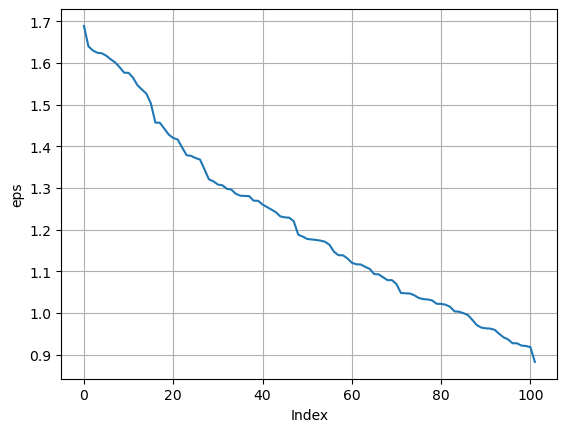


Clustering by hour 01:00:00...


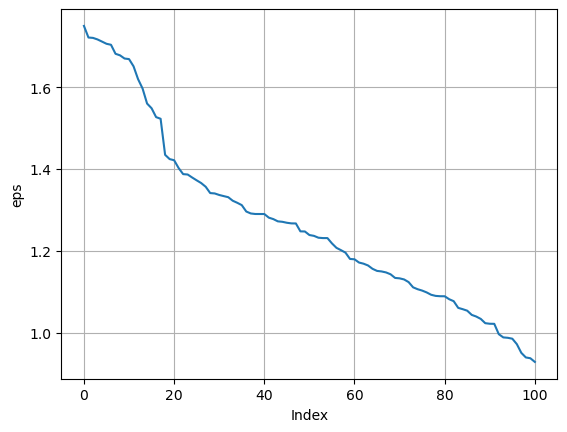


Clustering by hour 02:00:00...


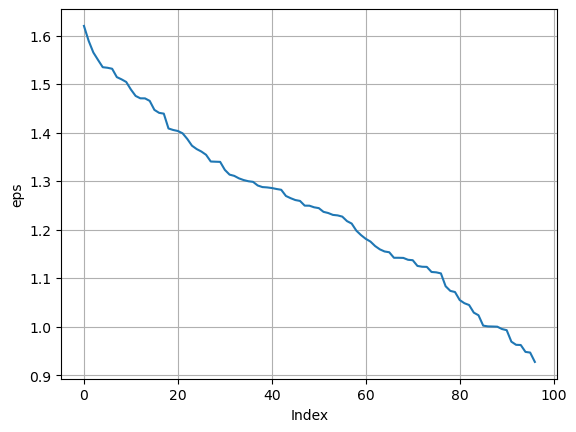


Clustering by hour 03:00:00...


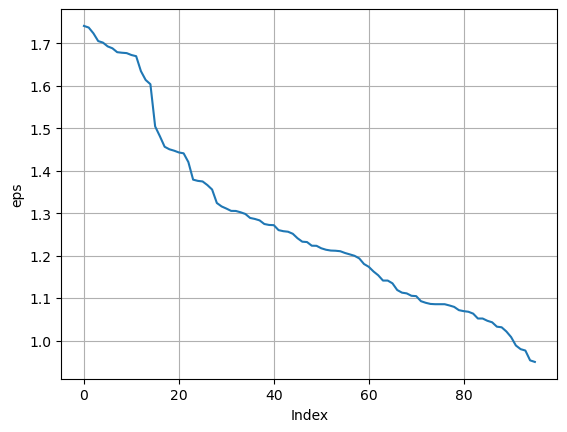


Clustering by hour 04:00:00...


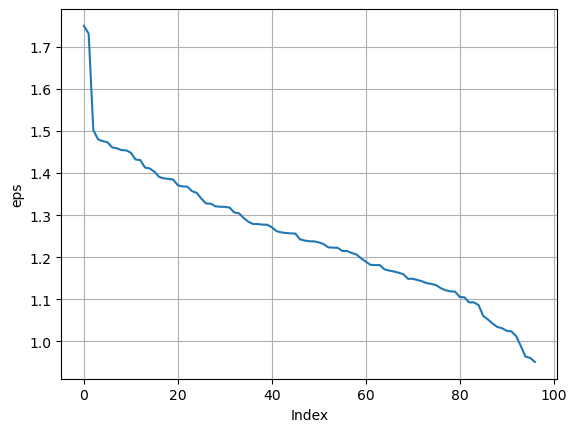


Clustering by hour 05:00:00...


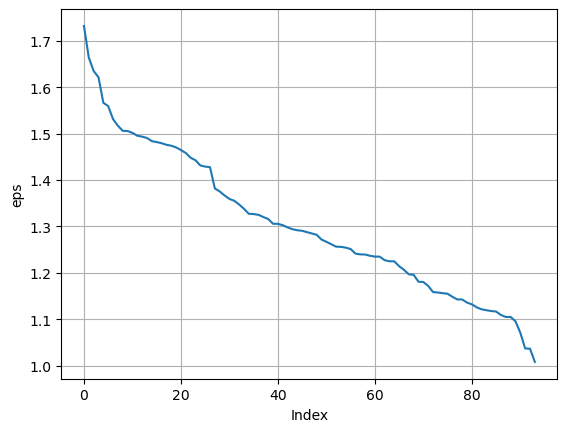


Clustering by hour 06:00:00...


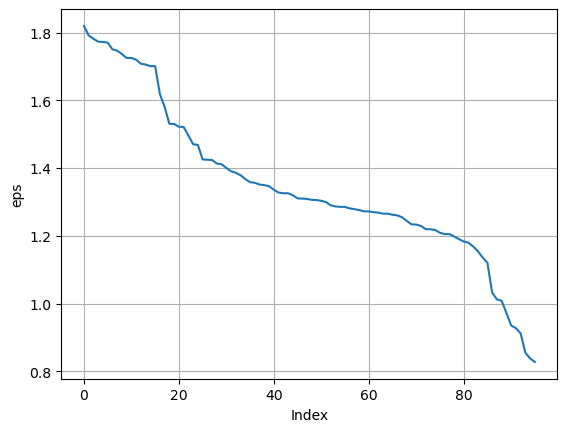


Clustering by hour 07:00:00...


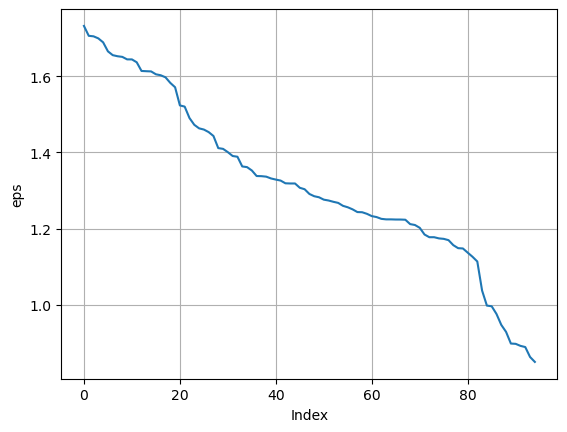


Clustering by hour 08:00:00...


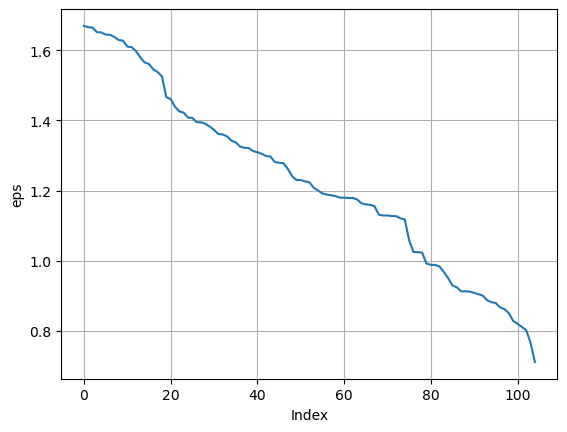


Clustering by hour 09:00:00...


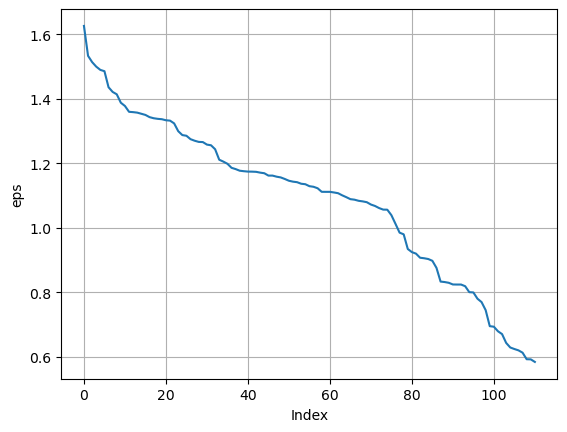


Clustering by hour 10:00:00...


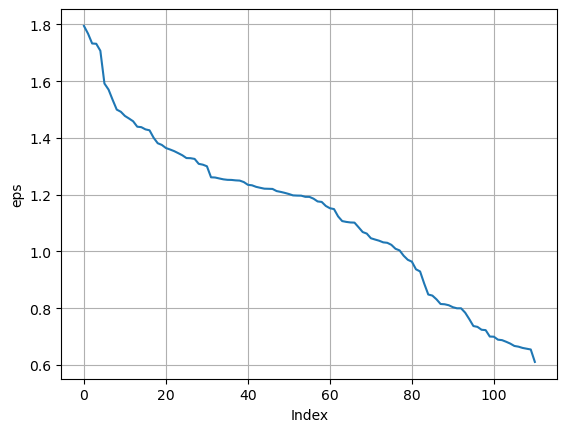


Clustering by hour 11:00:00...


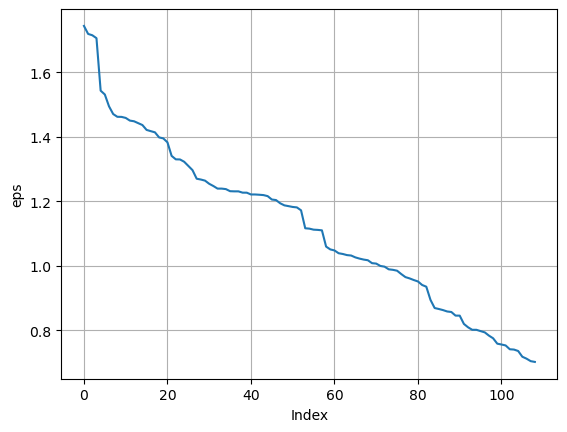


Clustering by hour 12:00:00...


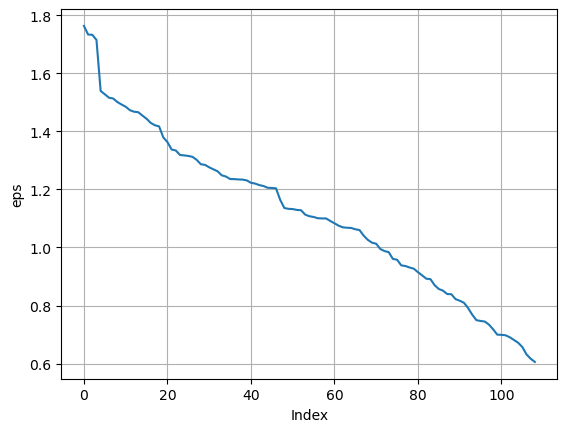


Clustering by hour 13:00:00...


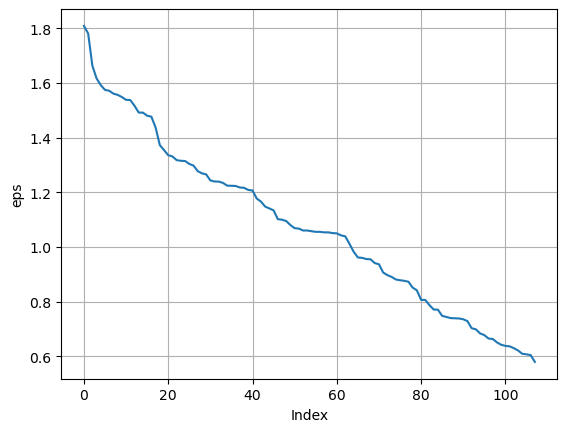


Clustering by hour 14:00:00...


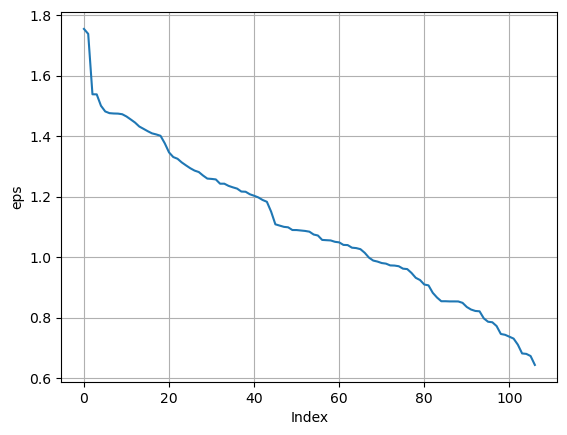


Clustering by hour 15:00:00...


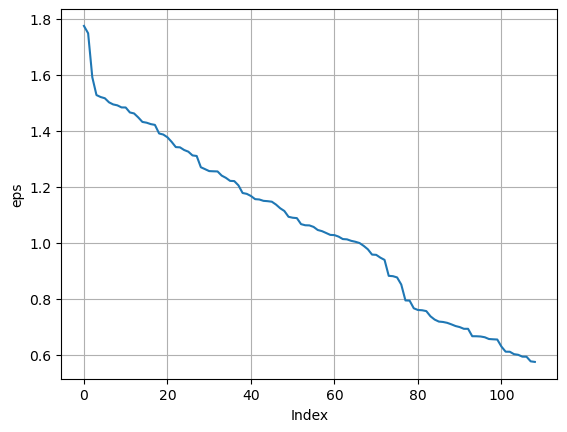


Clustering by hour 16:00:00...


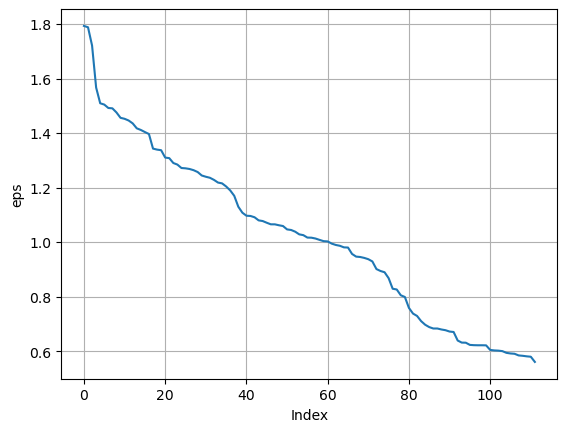


Clustering by hour 17:00:00...


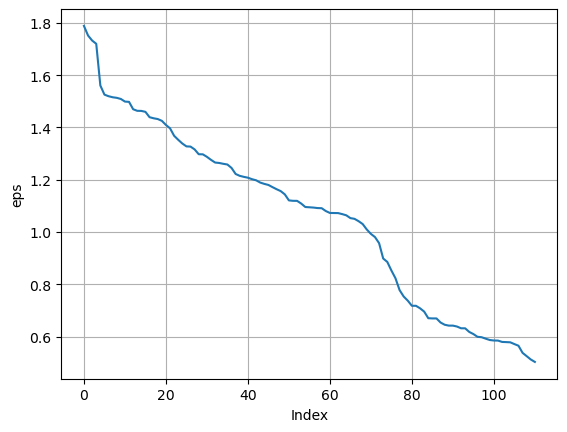


Clustering by hour 18:00:00...


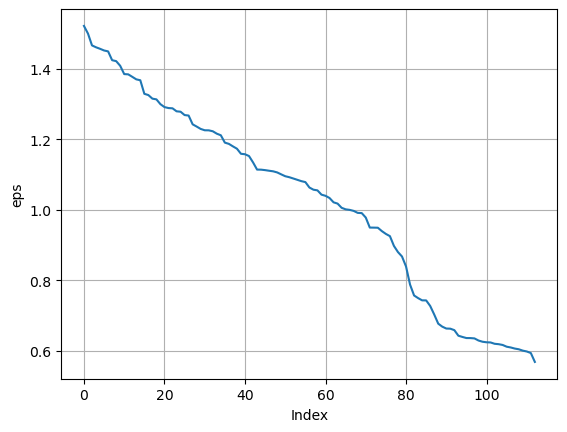


Clustering by hour 19:00:00...


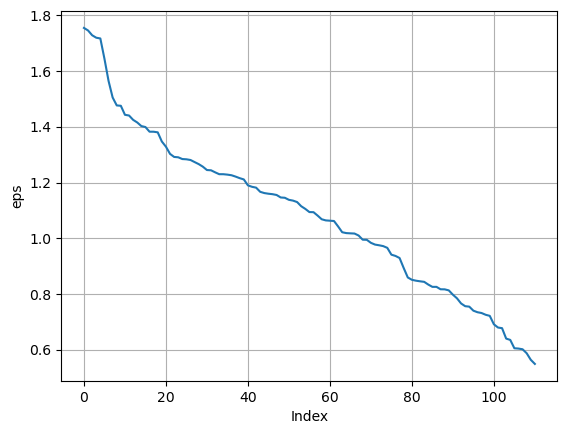


Clustering by hour 20:00:00...


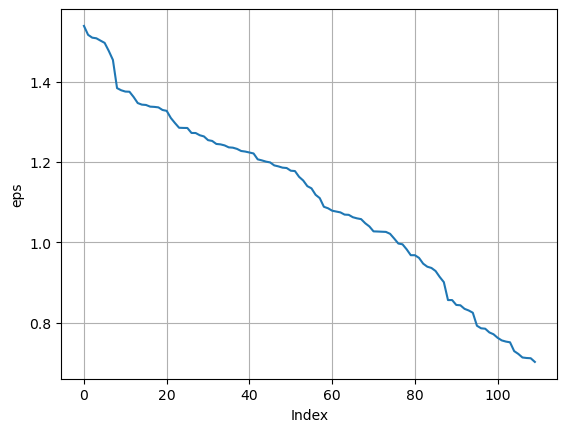


Clustering by hour 21:00:00...


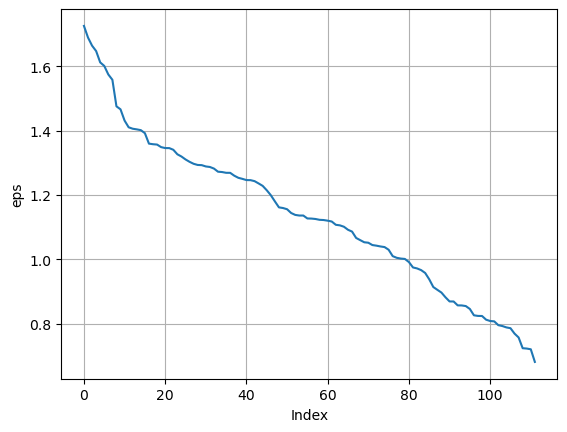


Clustering by hour 22:00:00...


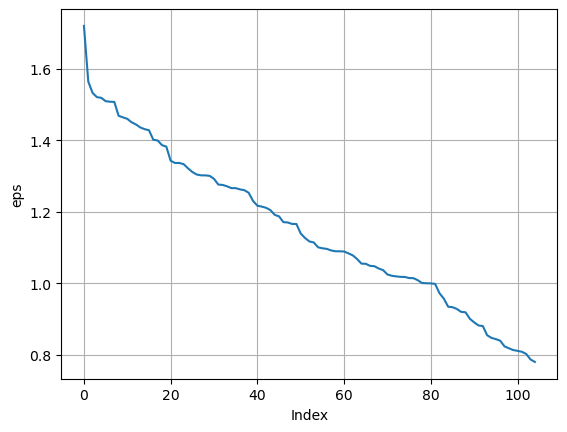


Clustering by hour 23:00:00...


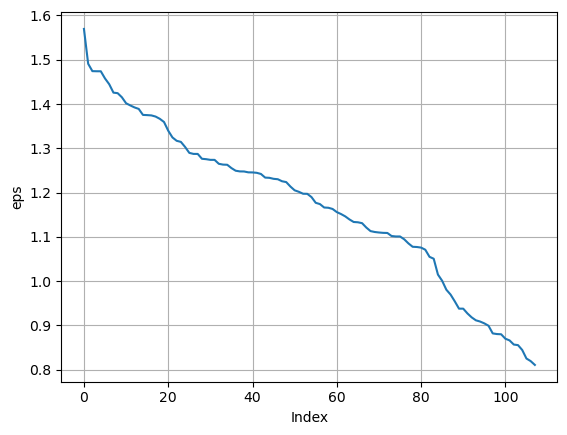

In [147]:
# scaler = MinMaxScaler()
# for hour, group in df_fall_2021.groupby('hour'):
#     print(f'\nClustering by hour {hour}...')
#     features = group.iloc[:, :16]
#     scaled_features = scaler.fit_transform(features)
    
#     DBSCAN_clustering(scaled_features)

In [97]:
eps_list = []
eps_range = np.linspace(0.1, 2.0, 20)
min_samples_range = range(4, 32, 2)

dbscan_clusters, best_eps_list, best_min_samples_list = dbscan_clustering_by_hour(df_fall_2021, eps_range, min_samples_range)

AttributeError: 'int' object has no attribute 'hour'

In [20]:
dbscan_clusters

{'00:00:00': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2,
        2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2]),
 '01:00:00': array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1,  0,  0,
        -1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]),
 '02:00:00': array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
         1

In [21]:
dbscan_labeled_fall_2021 = df_fall_2021[['time','date', 'hour']]
dbscan_labeled_fall_2021['hour'] = dbscan_labeled_fall_2021['hour'].astype(str)

dbscan_labeled_fall_2021['dbscan_labels'] = np.nan
for hour, labels in dbscan_clusters.items():
    dbscan_labeled_fall_2021.loc[dbscan_labeled_fall_2021['hour'] == hour, 'dbscan_labels'] = labels
dbscan_labeled_fall_2021['dbscan_labels'] = (dbscan_labeled_fall_2021['dbscan_labels'].astype(int))
dbscan_labeled_fall_2021['hour'] = dbscan_labeled_fall_2021['hour'].str.split(':').str[0].astype(int)
dbscan_labeled_fall_2021

,time,date,hour,dbscan_labels
2656,2020-08-18 14:00:00,2020-08-18,14,0
2657,2020-08-18 15:00:00,2020-08-18,15,0
2658,2020-08-18 16:00:00,2020-08-18,16,0
2659,2020-08-18 17:00:00,2020-08-18,17,0
2660,2020-08-18 18:00:00,2020-08-18,18,0
...,...,...,...,...
5191,2020-12-11 20:00:00,2020-12-11,20,-1
5192,2020-12-11 21:00:00,2020-12-11,21,2
5193,2020-12-11 22:00:00,2020-12-11,22,-1
5194,2020-12-11 23:00:00,2020-12-11,23,-1


In [24]:
df_labeled_fall_2021['dbscan_labels'] = dbscan_labeled_fall_2021['dbscan_labels']

In [27]:
from bokeh.palettes import Magma256
from bokeh.plotting import figure, show, output_notebook, output_file, save
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper
from collections import defaultdict
from bokeh.transform import linear_cmap
import numpy as np
from bokeh.models import ColorBar
from bokeh.models import PrintfTickFormatter
from bokeh.models.tickers import BasicTicker

# Convert cluster labels to integer type
dbscan_labeled_fall_2021['dbscan_labels'] = dbscan_labeled_fall_2021['dbscan_labels'].astype(int)

# Extract unique days in the dataset
unique_days = dbscan_labeled_fall_2021['date'].unique()

# Count connections between clusters of two consecutive hours
connection_count = defaultdict(int)
cluster_count = defaultdict(int)
cluster_points = defaultdict(int)

for day in unique_days:
    day_data = dbscan_labeled_fall_2021[dbscan_labeled_fall_2021['date'] == day]
    
    for i in range(len(day_data) - 1):
        hour1, cluster1 = day_data.iloc[i][['hour', 'dbscan_labels']]
        hour2, cluster2 = day_data.iloc[i + 1][['hour', 'dbscan_labels']]
        
        # Connect clusters of two consecutive hours only
        if hour2 - hour1 == 1:
            connection_count[(hour1, cluster1, hour2, cluster2)] += 1
            cluster_count[(hour1, cluster1)] += 1

    for i in range(len(day_data)):
        hour, cluster = day_data.iloc[i][['hour', 'dbscan_labels']]
        cluster_points[(hour, cluster)] += 1

# Prepare data for Bokeh lines
lines_x = []
lines_y = []
counts = []
for (hour1, cluster1, hour2, cluster2), count in connection_count.items():
    percentage = count / cluster_count[(hour1, cluster1)]
    lines_x.append([hour1, hour2])
    lines_y.append([cluster1, cluster2])
    counts.append(percentage)

source_lines = ColumnDataSource(data=dict(
    x=lines_x,
    y=lines_y,
    counts=counts,
))

# Prepare data for Bokeh points
points_x = []
points_y = []
points_count = []
for (hour, cluster), count in cluster_points.items():
    points_x.append(hour)
    points_y.append(cluster)
    points_count.append(count)

source_points = ColumnDataSource(data=dict(
    x=points_x,
    y=points_y,
    counts=points_count,
))

# Define color palette
palette = Magma256[::-1]

# Mapping the edge counts to a color
mapper = LinearColorMapper(palette=palette, low=min(counts), high=max(counts))

# Plotting
p = figure(title="kmeans - Fall 2021", x_axis_label='Hour', y_axis_label='Cluster labels',
           x_range=(-1, 24), y_range=(-2, max(dbscan_labeled_fall_2021['dbscan_labels'])+1), 
           width=1600, height=600, sizing_mode="scale_width", toolbar_location=None)

p.multi_line('x', 'y', source=source_lines, color={'field': 'counts', 'transform': mapper}, line_width=2)
points_renderer = p.circle('x', 'y', color='black', size=10, source=source_points)

color_bar = ColorBar(color_mapper=mapper, label_standoff=12, location=(0, 0),
                     ticker=BasicTicker(desired_num_ticks=len(palette)),
                     formatter=PrintfTickFormatter(format="%0.2f%%"))

p.add_layout(color_bar, 'right')

# Add a hover tool to display the count
hover_line = HoverTool(tooltips=[("Connectivity (%)", "@counts{0.2f}")], 
                       line_policy='nearest', point_policy='snap_to_data', 
                       renderers=[p.renderers[0]])

hover_point = HoverTool(tooltips=[("Cluster size", "@counts")], 
                        mode='mouse', renderers=[points_renderer])

p.add_tools(hover_line, hover_point)

# Display the plot
output_notebook()
show(p)

# Save the plot
output_file("./connectivity_plot/fall/2021/connectivity_plot_dbscan.html")
save(p)

Loading BokehJS ...

'/home/rhea_huang/isis/ESB_Anomaly_Detection/chillers/connectivity_plot/fall/2020/connectivity_plot_dbscan.html'

In [109]:
# Convert cluster labels to integer type
dbscan_labeled_fall_2021['dbscan_labels'] = dbscan_labeled_fall_2021['dbscan_labels'].astype(int)

# Extract unique days in the dataset
unique_days = dbscan_labeled_fall_2021['date'].unique()

# Count connections between clusters of two consecutive hours
connection_count = defaultdict(int)
cluster_count = defaultdict(int)
for day in unique_days:
    day_data = dbscan_labeled_fall_2021[dbscan_labeled_fall_2021['date'] == day]
    
    for i in range(len(day_data) - 1):
        hour1, cluster1 = day_data.iloc[i][['hour', 'dbscan_labels']]
        hour2, cluster2 = day_data.iloc[i + 1][['hour', 'dbscan_labels']]
        
        # Connect clusters of two consecutive hours only
        if hour2 - hour1 == 1:
            connection_count[(hour1, cluster1, hour2, cluster2)] += 1
            cluster_count[(hour1, cluster1)] += 1

In [110]:
from collections import Counter
from bokeh.models import ColumnDataSource, LinearColorMapper, ColorBar, PrintfTickFormatter
from bokeh.plotting import figure, output_file, save
from bokeh.palettes import Viridis256 as palette
from bokeh.models.tools import HoverTool

# Compute the sizes of the clusters for each hour
cluster_size = Counter([(row['hour'], row['dbscan_labels']) for idx, row in dbscan_labeled_fall_2021.iterrows()])
palette = Magma256[::-1]

threshold = 0.9
clusters = range(max(dbscan_labeled_fall_2021['dbscan_labels'])+1)
hours = range(24)

encountered_paths = set()
paths = []  # List to save the paths
idx = 0
start_hour = 0
while start_hour < len(hours):
    for start_cluster in clusters:
        path = generate_path(connection_count, cluster_count, start_hour, start_cluster)
        
        # Convert path to a string so it can be stored in a set
        path_str = '-'.join(str(hour_cluster) for hour_cluster in path)
        
        # Check if this path has been encountered before
        if path_str in encountered_paths:
            continue
            
        # Add this path to the set of encountered paths
        encountered_paths.add(path_str)
        
        # If path length is less than 2, don't add it to the paths list
        if len(path) < 2:
            continue
        
        # Add the path to the paths list
        paths.append(path)

        lines_x = []
        lines_y = []
        counts = []
        points_x = []
        points_y = []
        points_counts = []

        for i in range(len(path) - 1):
            hour1, cluster1 = path[i]
            hour2, cluster2 = path[i + 1]
            count = connection_count[(hour1, cluster1, hour2, cluster2)]
            lines_x.append([hour1, hour2])
            lines_y.append([cluster1, cluster2])
            
            # check if cluster_count[(hour1, cluster1)] is zero before performing the division
            if cluster_count[(hour1, cluster1)] != 0:
                counts.append(count / cluster_count[(hour1, cluster1)])
            else:
                counts.append(0)  # or some other value that indicates a missing or undefined count

            points_x.append(hour1)
            points_y.append(cluster1)
            points_counts.append(cluster_size[(hour1, cluster1)])


        source = ColumnDataSource(data=dict(x=lines_x, y=lines_y, counts=counts, 
                                            points_x=points_x, points_y=points_y, points_counts=points_counts))

        mapper = LinearColorMapper(palette=palette, low=min(counts), high=max(counts))

        p = figure(title=f"Threshold: {threshold*100}% - Path {idx + 1}", 
                   x_axis_label='Hour', y_axis_label='Cluster',
                   x_range=(-1, 24), y_range=(-1, max(clusters)+1), 
                   width=800, height=400, toolbar_location=None)

        p.multi_line('x', 'y', source=source, color={'field': 'counts', 'transform': mapper}, line_width=2)

        # Store the renderer of the points
        points_renderer = p.circle('points_x', 'points_y', color='black', size=10, source=source)

        color_bar = ColorBar(color_mapper=mapper, label_standoff=12, location=(0, 0),
                            ticker=BasicTicker(desired_num_ticks=len(palette)),
                            formatter=PrintfTickFormatter(format="%0.2f%%"))

        p.add_layout(color_bar, 'right')

        hover_line = HoverTool(tooltips=[("Connectivity (%)", "@counts{0.2f}")], 
                               mode='mouse', line_policy='nearest', point_policy='snap_to_data')
        hover_point = HoverTool(tooltips=[("Cluster size", "@points_counts")], 
                                mode='mouse', renderers=[points_renderer])

        p.add_tools(hover_line, hover_point)

        output_file(f"./connectivity_plot/fall/2021/dbscan/connectivity_plot_dbscan_{int(threshold*100)}_path_{idx + 1}.html")
        save(p)
        idx += 1

    # Advance to the hour following the last one in the current path
    start_hour = path[-1][0] + 1

In [112]:
all_lines_x = []
all_lines_y = []
all_points_x = []
all_points_y = []

for path in paths:
    lines_x = []
    lines_y = []
    points_x = []
    points_y = []

    for i in range(len(path) - 1):
        hour1, cluster1 = path[i]
        hour2, cluster2 = path[i + 1]
        
        lines_x.append([hour1, hour2])
        lines_y.append([cluster1, cluster2])

        points_x.append(hour1)
        points_y.append(cluster1)

    all_lines_x.append(lines_x)
    all_lines_y.append(lines_y)
    all_points_x.append(points_x)
    all_points_y.append(points_y)
plot_features(df_labeled_fall_2021, all_lines_x, all_lines_y, all_points_x, all_points_y, threshold, method='dbscan_labels')

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

# Feature by feature visualization

In [36]:
df_labeled_fall_2021 = df_fall_2021.copy()
df_labeled_fall_2021['kmeans_labels'] = kmeans_labeled_fall_2021['kmeans_labels']
df_labeled_fall_2021['dbscan_labels'] = dbscan_labeled_fall_2021['dbscan_labels']
df_labeled_fall_2021['hour'] = df_labeled_fall_2021['hour'].astype(str).str.split(':').str[0].astype(int)
df_labeled_fall_2021

,ESB Chiller Plant plantEfficiency,ESB_Chillers Demand,ESB_Chillers tonnage,ESB_Chillers Percent_Load Value,Active_Chiller_Load_Percent Value,Primary_CHW_Flow Value,Building_Load Value,ESB_Chillers chillerEvapDifferentialPress,ESB_Chillers chillerCondDifferentialPress,ESB_Chillers chillerEvapLeavingWaterTemp,...,ESB_Chillers chillerEvapWaterFlow,ESB_Chillers chillerCondEnteringWaterTemp,ESB_Chillers chillerCondLeavingWaterTemp,ESB_Chillers chillerEvapEnteringWaterTemp,ESB_Chillers outdoorAirTemp,time,date,hour,kmeans_labels,dbscan_labels
2656,0.5959,170.71,380.06,45.35,45.91,1822.90,478.74,5.2324,4.7747,42.28,...,1731.39,77.68,82.08,47.55,88.11,2020-08-18 14:00:00,2020-08-18,14,1,0
2657,0.6130,184.15,391.24,51.58,51.58,1816.70,525.64,5.2285,4.7490,42.48,...,1732.55,78.91,83.68,47.90,88.80,2020-08-18 15:00:00,2020-08-18,15,2,0
2658,0.6068,190.43,404.91,49.46,49.46,1808.71,504.16,5.2223,4.7537,42.14,...,1732.96,79.02,83.79,47.74,89.55,2020-08-18 16:00:00,2020-08-18,16,1,0
2659,0.6092,186.75,397.93,49.71,49.89,1831.57,510.50,5.2269,4.7729,42.16,...,1732.45,78.64,83.23,47.67,88.47,2020-08-18 17:00:00,2020-08-18,17,2,0
2660,0.6368,181.22,371.95,49.07,48.90,1817.68,499.74,5.2091,4.7657,42.28,...,1730.71,78.69,83.06,47.44,88.13,2020-08-18 18:00:00,2020-08-18,18,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,0.5070,54.38,184.31,24.52,24.52,1817.69,291.69,5.1988,0.5605,41.93,...,1723.81,57.71,61.23,44.50,60.09,2020-12-11 20:00:00,2020-12-11,20,0,-1
5192,0.5300,53.23,174.32,24.38,24.38,1817.91,295.17,5.1921,0.4446,41.88,...,1721.30,57.44,61.15,44.31,60.02,2020-12-11 21:00:00,2020-12-11,21,1,2
5193,0.5242,53.69,177.79,24.14,24.14,1817.72,298.21,5.1828,0.4626,41.86,...,1722.44,57.32,61.05,44.33,59.49,2020-12-11 22:00:00,2020-12-11,22,2,-1
5194,0.5393,54.06,172.92,20.16,20.16,1821.58,261.70,5.1894,0.7068,41.91,...,1722.57,57.94,61.26,44.32,58.21,2020-12-11 23:00:00,2020-12-11,23,4,-1


In [41]:
import matplotlib.pyplot as plt
import os
def plot_features(df, lines_x, lines_y, points_x, points_y, threshold, method):
    features = df.columns[:-5]

    # use tab10 colormap
    cmap = plt.get_cmap('tab10')

    for idx, (line_x, line_y, point_x, point_y) in enumerate(zip(lines_x, lines_y, points_x, points_y)):
        
        # Create a directory for each path
        dir_name = f"./connectivity_plot/fall/2021_feature_visualization/{method}/{idx + 1}"
        os.makedirs(dir_name, exist_ok=True)

        for feature_idx, feature in enumerate(features):
            plt.figure(figsize=(20,10))

            for hour in range(24):
                # get all points belonging to the cluster of that hour
                cluster = point_y[point_x.index(hour) if hour in point_x else -1]
                same_cluster_points = df[(df['hour'] == hour) & (df[method] == cluster)]
                feature_values = same_cluster_points[feature].tolist()

                # accommodate -1 values for dbscan_labels
                color_code = cluster if cluster >= 0 else len(df[method].unique()) - 1
                cluster_colors = [cmap(color_code % 10)] * len(feature_values)

                # plot for each feature
                plt.scatter([hour]*len(feature_values), feature_values, color=cluster_colors)

            plt.title(f"{method} - Fall 2021, Threshold: {threshold*100}% - Path {idx + 1} - Feature: {feature}")
            plt.xlabel('Hour')
            plt.ylabel(feature)
            plt.xlim(-1, 25)

            # create legend
            clusters = df[method].unique()
            legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                          markerfacecolor=cmap(cluster if cluster >= 0 else len(clusters) - 1), 
                                          markersize=10) for cluster in clusters]
            plt.legend(legend_elements, clusters, title="Clusters")

            # Save the figure to a file
            plt.savefig(f"{dir_name}/{feature_idx + 1}.png")

            # Clear the current figure to free memory
            plt.clf()


## Kmeans

In [34]:
all_lines_x = []
all_lines_y = []
all_points_x = []
all_points_y = []

for start_hour in range(24):
    for start_cluster in range(max(kmeans_labeled_fall_2021['kmeans_labels']) + 1):
        path = generate_path(connection_count, cluster_count, start_hour, start_cluster)
        
        if len(path) < 2:
            continue

        lines_x = []
        lines_y = []
        points_x = []
        points_y = []

        for i in range(len(path) - 1):
            hour1, cluster1 = path[i]
            hour2, cluster2 = path[i + 1]
            
            lines_x.append([hour1, hour2])
            lines_y.append([cluster1, cluster2])

            points_x.append(hour1)
            points_y.append(cluster1)

        all_lines_x.append(lines_x)
        all_lines_y.append(lines_y)
        all_points_x.append(points_x)
        all_points_y.append(points_y)
        
plot_features(df_labeled_fall_2021, all_lines_x, all_lines_y, all_points_x, all_points_y, threshold, method='kmeans_labels')

## DBSCAN

In [43]:
from collections import Counter
from bokeh.models import ColumnDataSource, LinearColorMapper, ColorBar, PrintfTickFormatter
from bokeh.plotting import figure, output_file, save
from bokeh.palettes import Magma256 as palette
from bokeh.models.tools import HoverTool
from collections import defaultdict
dbscan_labeled_fall_2021['dbscan_labels'] = dbscan_labeled_fall_2021['dbscan_labels'].astype(int)

# Extract unique days in the dataset
unique_days = dbscan_labeled_fall_2021['date'].unique()

# Count connections between clusters of two consecutive hours
connection_count = defaultdict(int)
cluster_count = defaultdict(int)
for day in unique_days:
    day_data = dbscan_labeled_fall_2021[dbscan_labeled_fall_2021['date'] == day]
    
    for i in range(len(day_data) - 1):
        hour1, cluster1 = day_data.iloc[i][['hour', 'dbscan_labels']]
        hour2, cluster2 = day_data.iloc[i + 1][['hour', 'dbscan_labels']]
        
        # Connect clusters of two consecutive hours only
        if hour2 - hour1 == 1:
            connection_count[(hour1, cluster1, hour2, cluster2)] += 1
            cluster_count[(hour1, cluster1)] += 1

# Compute the sizes of the clusters for each hour
cluster_size = Counter([(row['hour'], row['dbscan_labels']) for idx, row in dbscan_labeled_fall_2021.iterrows()])

threshold = 0.9
clusters = range(max(dbscan_labeled_fall_2021['dbscan_labels'])+1)
hours = range(24)

# Initialize lists to store paths
all_lines_x = []
all_lines_y = []
all_points_x = []
all_points_y = []
all_points_counts = []

idx = 0
start_hour = 0
while start_hour < len(hours):
    for start_cluster in clusters:
        path = generate_path(connection_count, cluster_count, start_hour, start_cluster)
        if len(path) < 2:
            continue

        lines_x = []
        lines_y = []
        counts = []
        points_x = []
        points_y = []
        points_counts = []

        for i in range(len(path) - 1):
            hour1, cluster1 = path[i]
            hour2, cluster2 = path[i + 1]
            count = connection_count[(hour1, cluster1, hour2, cluster2)]
            lines_x.append([hour1, hour2])
            lines_y.append([cluster1, cluster2])
            counts.append(count / cluster_count[(hour1, cluster1)])

            points_x.append(hour1)
            points_y.append(cluster1)
            points_counts.append(cluster_size[(hour1, cluster1)])

        # Store paths in lists
        all_lines_x.append(lines_x)
        all_lines_y.append(lines_y)
        all_points_x.append(points_x)
        all_points_y.append(points_y)
        all_points_counts.append(points_counts)

        # The rest of your code to generate and save the plot

    # Advance to the hour following the last one in the current path
    start_hour = path[-1][0] + 1

In [44]:
plot_features(df_labeled_fall_2021, all_lines_x, all_lines_y, all_points_x, all_points_y, 0.9, 'dbscan_labels')

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>